<a href="https://colab.research.google.com/github/spatank/CIS-522/blob/main/Tutorials/W12_Tutorial2_SPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 12 Part 2
# Revisiting AlphaZero

__Instructor:__ Dinesh Jayaraman

__Content creators:__ Chuning Zhu

---

In [1]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'spatank' #@param {type:"string"}
my_pod = 'sublime-newt' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','astute-jellyfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion']


---
# Setup

In [2]:
# imports
import gym
import math
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn 
from numba import cuda, float32, int32
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import IPython
from IPython.display import IFrame
from google.colab import output
from tqdm.notebook import tqdm
from typing import List
import time
import warnings

warnings.filterwarnings("ignore")

In [3]:
# @title Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

---
# Preface

Whew, what a long journey! We started off with a glorious introduction of AlphaZero, studied the basic components of deep learning, and grinded throught convnets, natural language processing, and reinforcement learning. Now, we stand at the end of Week 12, the last week of "real" material. In this tutorial, we will go all the way back to week 1 and revisit AlphaZero! The goal is to show that over the course of CIS 522, and particularly the RL weeks, you have been equipped with enough deep learning knowledge to truly understand how AlphaZero works! This will be purely an intellectual journey, and there will be no code for you to implement.

Before we dive in, let's take a small detour and briefly talk about how we can solve sequential decision making problems without rewards. 

---
# Section 1: Learning from Demonstrations

Video available at https://youtube.com/watch?v=hT7jp4JlnSM


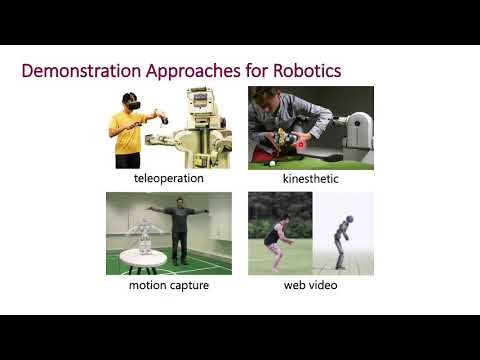

In [4]:
#@title Video : Imitation Learning

import time
try: t0;
except NameError: t0=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="hT7jp4JlnSM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

How can we train an agent to drive a car in real world? Obviously, there are so many scenarios that any attempt at designing a reward function would fail miserably. In addition, there is no good mechanism to issue the rewards. What we do have is plenty of human drivers, or experts. If experts can stay in the middle of the road, then we should be able to do the same by imitiating what the expert does for any given observation. This intuition leads to a method for solving sequential decision making problems without rewards -- **imitation learning**. In particular, what we just mentioned is called **behavioral cloning**. 

In behavioral cloning, we train a neural network to predict an action given a state. This is exactly a policy network, but rather than maximizing the reward, we simply maximize the log likelihood of the expert's action given an observation. Let $D$ denote a dataset of expert demonstrations, the objective of behavioral cloning is:
$$\theta = \arg\min_{\theta} E_{(s, a^*) \sim D}\left[\log \pi(a^*|s)\right]$$

Using plain behavioral cloning can lead to catastrophic failure. This is because the prediction error of our model compounds as we execute more actions, which eventually leads to a state not covered in the dataset's distribution. The model would have no idea what to do there. The **DAgger (Dataset Aggregation) algorithm** addresses this distributional shift by adding a data collection and labelling step to behaviorial cloning. In this way, it pulls the policy distribution closer to the data distribution, and provably leads to fewer errors. The pseducode is as follows:

```
Initialize dataset D with expert demonstrations
Repeat
    Train policy using observations and actions from D.
    Run policy to generate more observations O_new.
    Ask expert to label the observations with actions A_new. Get D_new = {O_new, A_new}.
    Aggregate D = {D, D_new}.
```

## Exercise 1: Behavioral Cloning

In this exercise, you will use behavioral cloning to solve the CartPole environment. Run the first cell to train an expert policy using policy gradient, which should take about 3 minutes. Then, run the second cell to collect expert demonstrations. We store the data in a replay buffer of states and actions. Finally, follow the instuctions to complete the training and model update functions of behavior cloning. Since the dynamics of CartPole is very simple, we don't need DAgger to solve it.

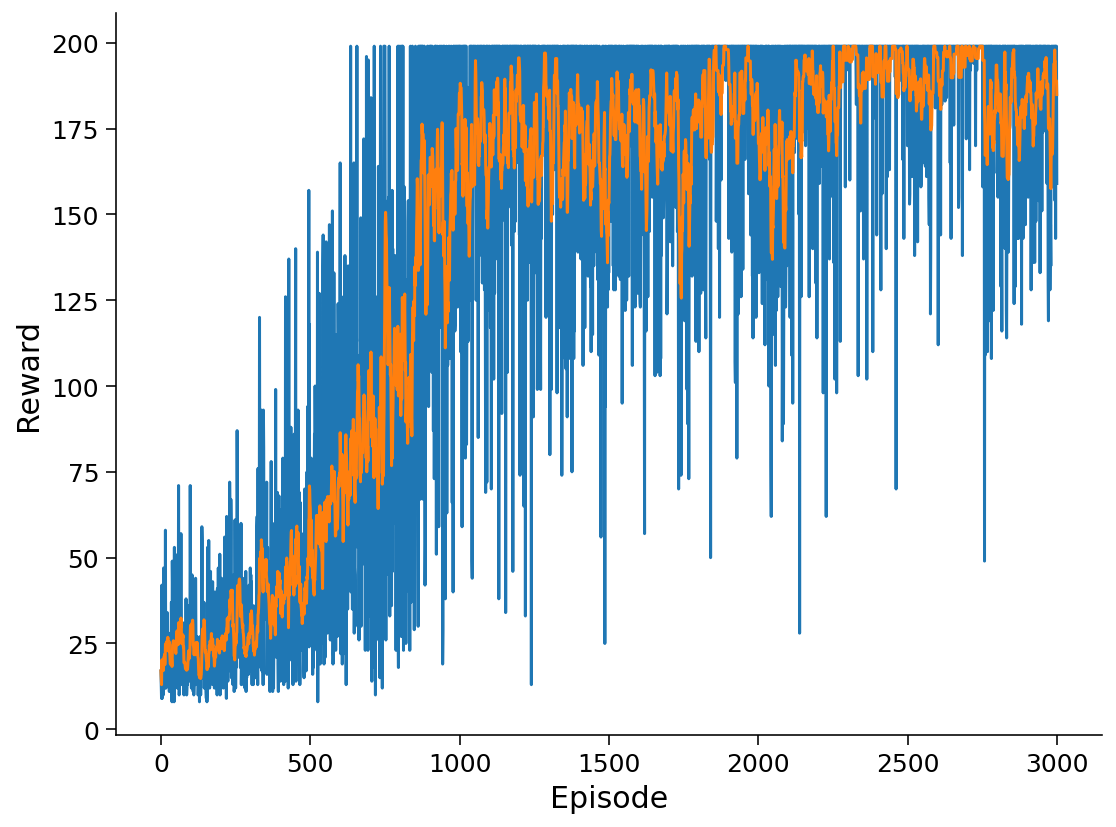

In [5]:
# @markdown ## Train expert using policy gradient

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()
        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state)
        action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[action])
        return action, log_prob

## Update
def update_policy(policy_network, rewards, log_probs, gamma):
    discounted_rewards = []
    for t in range(len(rewards)):
        Gt = 0 
        pow = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**pow * r
            pow = pow + 1
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    # Add whitening
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradients = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradients.append(-log_prob * Gt)
    
    policy_network.optimizer.zero_grad()
    objective = torch.stack(policy_gradients).sum()
    objective.backward()
    policy_network.optimizer.step()

## Main loop
def reinforce_whitening(env, policy):
    
    max_episode_num = 3000
    max_steps = 10000
    numsteps = []
    avg_numsteps = []
    all_rewards = []

    for episode in tqdm(range(max_episode_num),position=0, leave=True):
        state = env.reset()
        log_probs = []
        rewards = []

        for steps in range(max_steps):
            action, log_prob = policy_net.get_action(state)
            new_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                update_policy(policy_net, rewards, log_probs, 0.9)
                numsteps.append(steps)
                avg_numsteps.append(np.mean(numsteps[-10:]))
                all_rewards.append(np.sum(rewards))
                break
            state = new_state
        
    plt.plot(numsteps)
    plt.plot(avg_numsteps)
    plt.ylabel("Reward")
    plt.xlabel('Episode')
    plt.show()

device = torch.device("cpu")
env = gym.make('CartPole-v0')
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)
policy_net = policy_net.to(device)
reinforce_whitening(env, policy_net)

In [6]:
# @markdown ## Collect expert data

class ReplayBuffer:
  def __init__(self, state_dim, act_dim, buffer_size):
    self.buffer_size = buffer_size
    self.ptr = 0
    self.n_samples = 0

    self.state = torch.zeros(buffer_size, *state_dim, dtype=torch.float32, device=device)
    self.action = torch.zeros(buffer_size, act_dim, dtype=torch.int64, device=device)

  def add(self, state, action):
    self.state[self.ptr] = torch.tensor(state)
    self.action[self.ptr] = torch.tensor(action)
    if self.n_samples < self.buffer_size:
      self.n_samples += 1
    self.ptr = (self.ptr + 1) % self.buffer_size

  def sample(self, batch_size):      
    # Select batch_size number of sample indicies at random from the buffer
    idx = np.random.choice(self.n_samples, batch_size)    
    # Using the random indices, assign the corresponding state and action
    state = self.state[idx]
    action = self.action[idx]
    return state, action

def collect_expert_data(env, expert, num_samples=10000):
    print('Collecting expert data...')
    replay_buffer = ReplayBuffer(state_dim=(4,), act_dim=1, buffer_size=num_samples)
    state = env.reset()
    while replay_buffer.n_samples < replay_buffer.buffer_size:
        # Sample a random action
        action, log_prob = expert.get_action(state)
        # Execute action in environment
        next_state, reward, done, _ = env.step(action)
        # Add to replay buffer
        replay_buffer.add(state, action)
        # Update state
        state = next_state
        if done:
            state = env.reset()
    print('Done!')
    return replay_buffer

replay_buffer = collect_expert_data(env, policy_net)

Done!


Epoch [0/10], loss: 0.6673882311582565, reward: 42.0
Epoch [1/10], loss: 0.6215937361121178, reward: 200.0
Epoch [2/10], loss: 0.6069087035953998, reward: 200.0
Epoch [3/10], loss: 0.5784015269577503, reward: 141.0
Epoch [4/10], loss: 0.5761939835548401, reward: 200.0
Epoch [5/10], loss: 0.5658583755791188, reward: 200.0
Epoch [6/10], loss: 0.5697261546552181, reward: 200.0
Epoch [7/10], loss: 0.5818599677085876, reward: 200.0
Epoch [8/10], loss: 0.5614539363980293, reward: 200.0
Epoch [9/10], loss: 0.5423708982765675, reward: 200.0



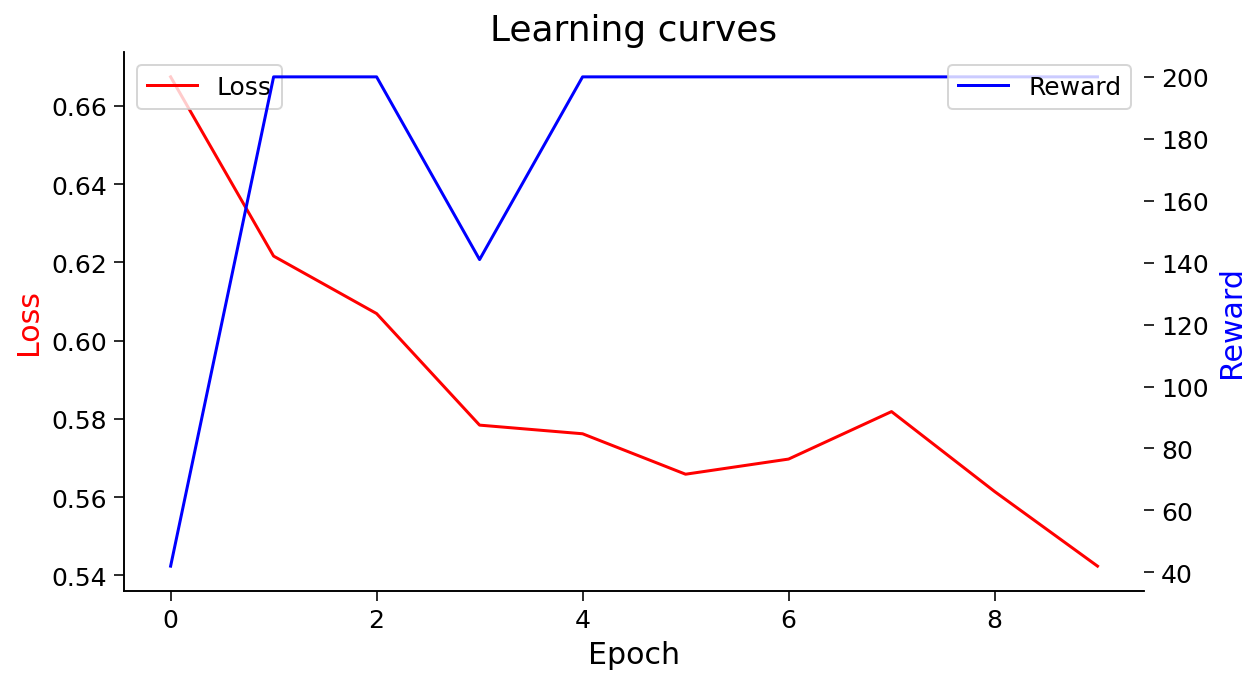

In [7]:
class BCAgent(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(BCAgent, self).__init__()
        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, state):
        x = F.relu(self.linear1(state))
        # We don't use softmax here because CrossEntropyLoss does that already.
        x = self.linear2(x)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = F.softmax(self.forward(state), dim=1)
        action = torch.argmax(probs, dim=1)
        return action.numpy()[0]
    
    def update(self, state, action):
        # Get output from model
        output = self.forward(state)
        # Compute cross-entropy loss
        loss = self.criterion(output, action.squeeze())
        # Take gradient step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()


def behavioral_cloning(env, agent, buffer, num_epochs=10, iters_per_epoch=200, batch_size=50):
    epoch_losses = []
    epoch_rewards = []
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0
        for i in range(iters_per_epoch):
            # Sample a batch of states and actions from the buffer
            state, action = buffer.sample(batch_size)
            # Update agent
            loss = agent.update(state, action)
            total_loss += loss
        # Log average loss
        epoch_losses.append(total_loss / iters_per_epoch)
        # Evaluate in environment
        total_reward = 0
        done = False
        state = env.reset()
        while not done:
            with torch.no_grad():
                action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state
        epoch_rewards.append(total_reward)
        print(f'Epoch [{epoch}/{num_epochs}], loss: {epoch_losses[-1]}, reward: {epoch_rewards[-1]}')
    return epoch_losses, epoch_rewards

# Uncomment to test
agent = BCAgent(env.observation_space.shape[0], env.action_space.n, 128)
losses, rewards = behavioral_cloning(env, agent, replay_buffer, batch_size=10)

# Plot learning curves
plt.figure(figsize=(9, 5))
plt.title('Learning curves')
ax = plt.gca()
ax.plot(losses, label="Loss", c='r')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss', c='r')
plt.legend(loc="upper left")
axtwin = ax.twinx()
axtwin.plot(rewards, label="Reward", c='b')
axtwin.set_ylabel('Reward', c='b')
plt.legend(loc="upper right")
plt.show()

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/W12_Tutorial2_Solution_Ex01.py)

*Example output:*  

<img alt='Solution hint 1' align='left' width=630 height=350 src=https://raw.githubusercontent.com/CIS-522/course-content/main/tutorials/W12_DeepRL/static/W12_Tutorial2_Solution_Ex01.png />

In [8]:
#@markdown If we were to extend the code to DAgger, how could we use the expert to relabel new experiences?
dagger_relabel = "Use the trained expert's policy network to assign actions to unseen states." #@param {type:"string"}

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/dagger_relabel.md)

---
# Section 2: Back to AlphaZero

## Key concepts in RL

We are now ready to see our old friend AlphaZero again. Let's summarize a few key concepts in reinforcement learning introduced over the past two weeks, and try to connect them to AlphaZero in the rest of the tutorial. 

- Recall that a reinforcement learning problem can be formalized as a **Markov Decision Process (MDP)**. A MDP is a tuple $(S, A, P, R, \gamma)$, where $S$ denote the set of states, $A$ the set of actions, $P$ the transition function, $R$ the reward function, and $\gamma$ the discount factor. An MDP satisfies the Markov property since the reward and transition can be determined from the current state and action, without knowing the history. The reward is typically a function of state and action, but we can also have it be a function of state, or of state, action and next state. 
- A **policy** is a mapping from states to distributions over actions. The objective of reinforcement learning is to find a policy that maximizes the expected total reward: $$ \pi^* = \arg\max_{\pi}E_{\pi}\left[\sum_{t=0}^{\infty} \gamma^t R(s_t, a_t)\right]$$
- The **value** of a state $V^{\pi}(s)$ is defined as the expected total reward obtained by following policy $\pi$ starting from state $s$. The value of a state-action pair, or the **Q-value**, $Q^{\pi}(s, a)$ is defined as the expected total reward obtained by taking action $a$ at state $s$ and then following policy $\pi$. Value and Q-value satisfy the Bellman equations. Using the Bellman equations, we can derive two algorithms for solving MDP with known transitions: **policy iteration** and **value iteration**.
- To solve an MDP without knowledge of its transitions, we can use **temporal difference (TD) learning**. The idea is to update the value estimate of state $s_{t}$ by bootstraping a value of $s_{t+1}$ from the current value estimates. Two instantiations of TD learning are **Q-learning** and **SARSA**. Later in actor-critic methods we also saw $n$-step TD-methods, where we bootstrap a value after rolling out $n$ steps.
- **Deep Q-learning** extends Q-learning to large state spaces by approximating the Q-values with a deep neural net. We need a few tricks to get it to work well, including replay buffer, target network, and double DQN. Deep Deterministic Policy Gradient (DDPG) further extends DQN to continuous action spaces.
- **Policy gradient method** (REINFORCE) directly optimizes a neural-network-parametrized policy using gradient ascent. Since the objective involves an expectation, we need to use a score function estimator and Monte-Carlo sampling to estimate the gradient. The vanilla policy gradient suffers from a high variance, which we mitigate with reward-to-go and discounting.
- To further reduce the varaince of policy gradients, we can subtract an unbiased baseline from the cumulative future reward term. A good baseline is the value function. This lead to the **actor-critic algorithm**, in which we jointly train an actor (policy) and a critic (value function). 

Finally, here are some recurring themes:
- **On-policy vs Off-policy**: A method is on-policy if learning needs to be done with examples generated using the current policy, and off-policy otherwise. Q-learning is off-policy, whereas SARSA is on-policy. DQN is off-policy, whereas policy gradient is on-policy. 
- **Model-based vs Model-free**: A model-based RL algorithm approximates the dynamics of an environment using a model (e.g. neural network). It then plans from the model or use the model to provide additional training data for model-free algorithms. 
- **Exploration vs exploitation**: In any RL algorithm, we need to balance exploration and exploitation. Particularly, we need to make sure that the algorithm explores enough states to be able to learn the optimal policy. In Q-learning, this is handled by episilon-greedy policy, whereas a stochastic policy in policy gradient automatically takes care of that.

In the remaining sections of the tutorial, there will be no video or code for you to implement. Thus, we encourage you to turn on your cameras and work through the rest of the tutorial with your pod. 


## The Othello Game

Recall that the game of Othello involves two players and an 8x8 (or 6x6) board. Initially, four stones are placed at the center of the board. Players 1 (black) and player 2 (white) take turns placing stones on the board. A move is legal if 1) its position is adjacent to one of opponent's pieces, and 2) placing the stone will cause a "flip": all of opponents pieces trapped between the new piece and exisiting pieces are flipped. When neither player has a legal move, the player with  more stones on the board wins the game. Run the following code cells and make a few moves to familiarize yourself with the rules.

In [9]:
#@markdown OthelloGame and InteractiveOthelloGame

# Environment config so that numba knows where to find CUDA libraries
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

# 1st dimension is row, 2nd is col. Top-left corner of board is (0,0). 8 vector
# directions out from each point are:
RAYS = np.array([[0, 1],   # east
                 [0, -1],  # west
                 [1, 0],   # south
                 [-1, 0],  # north
                 [1, 1],   # southeast
                 [1, -1],  # southwest
                 [-1, 1],  # northeast
                 [-1, -1]],# northwest
                dtype=np.int32)

# ======================================
# === BEGIN CUDA-ACCELERATED HELPERS ===
# ======================================

def torch2cuda(arr:torch.Tensor) -> cuda.cudadrv.devicearray.DeviceNDArray:
    return cuda.as_cuda_array(arr)

def cuda2torch(arr:cuda.cudadrv.devicearray.DeviceNDArray) -> torch.Tensor:
    return torch.as_tensor(arr, device='cuda')

@cuda.jit(device=True)
def cuda_cast_rays(board, y0, x0, ray, player):
    """Helper CUDA kernel that searches out from row, column coordinate (y0,x0)
    in the direction specified by "ray". Returns True iff there is an unbroken
    line of opponent stones along the ray starting at (y0,x0), ending with a
    stone belonging to "player".
    
    The device=True decorator means that this may only be called from other CUDA
    kernels (see below).
    """
    n = board.shape[1]
    opponent = 3 - player
    y, x = y0+ray[0], x0+ray[1]

    # The ray must begin with an opponent stone 1 space away
    if x < 0 or y < 0 or x >= n or y >= n or board[y, x] != opponent:
        return False
    
    # Keep looking until edge of the board or we find an open space or we find
    # a player-owned stone
    y, x = y+ray[0], x+ray[1]
    while x >= 0 and y >= 0 and x < n and y < n:
        # Ray terminates on an open space. Not a valid move.
        if board[y, x] == 0:
            return False
        
        # Ray terminates on player. This is valid!
        if board[y, x] == player:    
            return True
        
        y, x = y+ray[0], x+ray[1]
        
    # Reached end of the board. Not a valid move.
    return False

@cuda.jit
def cuda_get_valid_actions(boards, player, valid_actions):
    """Helper CUDA kernel that calls cuda_cast_rays to find all legal moves
    in parallel across many boards and positions. Results are written into the
    array "valid_actions" which must be the same shape as "boards".

    Decorating with @cuda.jit means we can call it from python by passing cuda
    device array objects for "board" and "valid_actions".

    CUDA is structured by 'blocks' and 'threads'. Each block contains multiple
    threads. It is the caller's job to say how many of each and their effective
    size. For instance, cuda_get_valid_actions[4, (8,8)](...) is the syntax for
    "4 blocks, each of which has 8 'x' and 8 'y' threads".

    We use a separate block per board, and each thread evaluates a single board
    coordinate.
    """
    # From numba documentation: const.array_like copies the given array into
    # constant GPU memory *at compile time*. This means the copy only happens
    # the first time this function is called.
    rays = cuda.const.array_like(RAYS)

    # We access boards through the 1d block index (boardIdx.x) and positions
    # within the board through the thread index x and y.
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    
    # If a space is occupied, it's an illegal move and we're done. Store a zero
    # at coordinate (ty, tx) on board bx.
    if boards[bx, ty, tx] != 0:
        valid_actions[bx, ty, tx] = 0
        return

    # Try out all 8 ray directions. If any one is a hit, set return value to 1
    # and break.
    for i in range(8):
        hit = cuda_cast_rays(boards[bx], ty, tx, rays[i], player)
        if hit:
            valid_actions[bx, ty, tx] = 1
            return
    
    # We tried all of the rays and none were legal capturing moves.
    valid_actions[bx, ty, tx] = 0

@cuda.jit
def cuda_step(boards, actions, player):
    """Helper CUDA kernel for playing actions across multiple boards in parallel.

    Boards must be [num_games, n, n], actions must be [num_games, 2] and player
    must be 1 or 2. Actions are (row, col) indices of the player's stone.

    WARNING: no legality checks are performed here! It is the caller's
    responsibility to ensure that all moves are legal.

    Boards are indexed by block x and the 8 ray directions by thread x

    If either of actions[b,:] is -1, treated as pass.
    """
    # As in cuda_get_valid_actions, this copy happens once at compile time
    rays = cuda.const.array_like(RAYS)

    # Grab thread and block index from cuda context
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x  

    # Unpack the row, col coordinate of the action
    act_y, act_x = actions[bx]

    # If -1, the player passed and there is nothing to do.
    if act_x == -1 or act_y == -1:
        return

    # Search a different ray direction on each of 8 threads. ASSUMES the move
    # is legal.
    is_hit = cuda_cast_rays(boards[bx], act_y, act_x, rays[tx], player)
    if is_hit:
        dy, dx = rays[tx]
        opponent = 3 - player
        y, x = act_y+dy, act_x+dx
        while boards[bx, y, x] == opponent:
            # Modify the board, flipping opponent to player
            boards[bx, y, x] = player
            y, x = y+dy, x+dx
    
    # Only need to do this once, so just let thread #0 handle it: update
    # the board at location of the action
    if tx == 0:
        boards[bx, act_y, act_x] = player

@torch.jit.script
def zobrist_hash(boards:torch.Tensor, player:torch.Tensor, table:torch.Tensor, out:torch.Tensor):
    n_games, n, _ = boards.size()
    flat_boards = boards.reshape(n_games, n*n)
    bit_strings = table[torch.arange(n*n), flat_boards.long()]
    # Reset output values to 0
    out.fill_(0)
    # We have to loop manually because bitwise_xor has no dimension
    # argument (see https://github.com/pytorch/pytorch/issues/35641)
    for i in range(n*n):
        torch.bitwise_xor(out, bit_strings[:,i], out=out)
    # Just add the current player - ok that this isn't random bitstrings because
    # just a single integer added per game.
    torch.add(out, player, out=out)
    return out

# ====================================
# === BEGIN OTHELLOGAME DEFINITION ===
# ====================================

class OthelloGame(object):
    PLAYER1 = 1
    PLAYER2 = 2
    ACTIVE = 0
    OVER = 1
    PASS = (-1, -1)
    # Unicode characters for dark and light circles if printing to console.
    # By convention, player 1 is dark and 2 is light.
    GAME_SYMBOLS = ['_', '\u25cf', '\u25cb']

    def __init__(self, n_games=1, n=8):
        """Create a new batch of n_games othello games each with board size [n,n]

        The game states are managed on the GPU with the help of CUDA kernels.

        We expect all n games to update in lockstep, so that there is only one
        'current_player' shared by all of them.
        """
        self.n_games = n_games
        self.n = n
        self.boards = torch.zeros((n_games, n, n), dtype=torch.float32, device='cuda')
        # Initial positions: 4 stones in the center alternating color
        self.boards[:, [self.n//2, self.n//2-1], [self.n//2, self.n//2-1]] = OthelloGame.PLAYER2
        self.boards[:, [self.n//2, self.n//2-1], [self.n//2-1, self.n//2]] = OthelloGame.PLAYER1
        # Always start with player 1 (dark stones by convention)
        self.current_player = OthelloGame.PLAYER1
        # All games are initially active
        self.game_status = OthelloGame.ACTIVE*torch.ones(n_games, dtype=torch.int32, device='cuda')
        # If both players pass the game is over. Keep track of whether the last
        # player passed.
        self.last_player_pass = torch.zeros(n_games, dtype=torch.int32, device='cuda')

        # _valid_moves is a container for storing which moves are valid. It is
        # zero everywhere except where it is legal to play, which is 1.
        self._valid_moves = torch.zeros_like(self.boards)

        # Create a CUDA device array copy of each GPU tensor. These share GPU
        # memory with torch tensors so any changes made in CUDA kernels are seen
        # by torch.
        self._cuda_boards = torch2cuda(self.boards)
        self._cuda_valid = torch2cuda(self._valid_moves)

        # Populate valid moves using CUDA-ized algorithm
        self.refresh_legal()

        # Initialize 'zobrist hash' table for get_uid() function
        self._new_zobrist_table()

    def step(self, actions:torch.Tensor):
        """Place a stone for the current player at location action=(row,col)
        separately per board. Expected size of 'actions' is [n_games, 2].

        Action coordinates of -1 treated as passing.

        Actions are ignored for all games that are not in the ACTIVE state.

        Note: no legality checking here! It is the caller's responsibility to
        ensure 'action' is legal, e.g. by checking that action is in
        game.get_available_actions().
        """
        # Ensure actions is a torch tensor and on the GPU. Ensure its shape is
        # [n_games, 2] even if the input was, say, just a (row,col) tuple.
        actions = torch.as_tensor(actions, device='cuda').view(-1, 2)

        # Ensure actions are "pass" for games that have completed. This tells
        # the cuda_step kernel to ignore these games.
        actions[self.game_status == OthelloGame.OVER, :] = -1

        # Update board state with call to CUDA kernel cuda_step.
        cuda_step[self.n_games, RAYS.shape[0]](self._cuda_boards, torch2cuda(actions), self.current_player)

        # Advance to the next player (2->1 and 1->2).
        self.current_player = 3-self.current_player

        # Count passes - any games with 2 passes in a row is flagged as being over.
        is_pass = torch.any(actions == -1, dim=1)
        self.last_player_pass[~is_pass] = 0
        self.last_player_pass[is_pass] += 1

        # Flag games that have finished
        is_game_over = self.last_player_pass >= 2
        self.game_status[is_game_over] = OthelloGame.OVER

        # Refresh legal moves for the next turn
        self.refresh_legal()
    
    def refresh_legal(self):
        # Look for valid moves in the updated boards for the new player
        cuda_get_valid_actions[self.n_games, (self.n, self.n)](self._cuda_boards, self.current_player, self._cuda_valid)

    def copy_state(self, idx=None):
        # Grab the minimal amount of state info to be able to return the board
        # to its current configuration later with a call to paste_state.
        # NOTE: this copy is single-use only; once it is pasted, it will be
        # modified in-place!
        return {"boards": self.boards.clone(),
                "game_status": self.game_status.clone(),
                "last_player_pass": self.last_player_pass.clone(),
                "current_player": self.current_player}

    def paste_state(self, state):
        self.__dict__.update(state)
        self._cuda_boards = torch2cuda(self.boards)
        self._cuda_valid = torch2cuda(self._valid_moves)
        cuda_get_valid_actions[self.n_games, (self.n, self.n)](self._cuda_boards, self.current_player, self._cuda_valid)

    def render(self, mode='human'):
        boards = self.boards.cpu()
        acts = self.get_available_actions()
        for g in range(self.n_games):
            if mode == 'text':
                print("="*(self.n-1) + (f"{OthelloGame.GAME_SYMBOLS[self.current_player]}")*2 + "="*(self.n-1))
                for row in boards[g]:
                    print(" ".join(OthelloGame.GAME_SYMBOLS[v] for v in row))
                print("="*(self.n*2))
            else:
                # Plot with matplotlib patches. Player 1 is dark and 2 is light.
                fig, ax = plt.subplots(figsize=(6,6))
                ax.set_aspect('equal')
                rect = patches.Rectangle((0,0),self.n,self.n,linewidth=1,edgecolor='k',facecolor='g')
                ax.add_patch(rect)
                ax.set_xlim(0,self.n)
                ax.set_ylim(0,self.n)
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.tick_params(length=0)
                ax.grid(which='major', zorder=0, c='k')
                for i in range(self.n):
                    for j in range(self.n):
                        if boards[g,i,j]>0:
                            # Draw stones
                            c = (0,0,0,1) if boards[g,i,j]==OthelloGame.PLAYER1 else (1,1,1,1)
                            circ = patches.Circle((j+.525,self.n-1-i+.5), .4, 
                                                facecolor=c, linewidth=1,edgecolor='k')
                            ax.add_patch(circ)
                        elif (i,j) in acts[g]:
                            # Draw transluscent stones on legal move positions
                            c = (0,0,0,0.25) if self.current_player==OthelloGame.PLAYER1 else (1,1,1,0.25)
                            circ = patches.Circle((j+.525,self.n-1-i+.5), .4, facecolor=c, linewidth=0)
                            ax.add_patch(circ)
                plt.show()

    def get_available_actions(self):
        """Get a list of all legal actions for the current player (passing not included).
        
        Note: assumes self._valid_moves is up to date!
        """
        acts = [None]*self.n_games
        for g in range(self.n_games):
            i, j = torch.where(self._valid_moves[g] == 1)
            acts[g] = list(zip(i.cpu().numpy(), j.cpu().numpy()))
        return acts

    def are_games_over(self):
        return torch.all(self.game_status == OthelloGame.OVER).item()

    def score_games(self):
        """Compute [n_games, 2] tuple containing "scores" for player 1 and 2 in
        each column. Assumes game is over.

        scores[:,0] is +1 if player 1 won, 0 for draw, or -1 for loss
        scores[:,1] is the same from player 2's perspective
        """
        flat_boards = self.boards.view(self.n_games, -1)
        n_dark = torch.sum(flat_boards == OthelloGame.PLAYER1, dim=1)
        n_lite = torch.sum(flat_boards == OthelloGame.PLAYER2, dim=1)
        scores = torch.zeros_like(n_dark)
        scores[n_dark > n_lite] = +1
        scores[n_dark < n_lite] = -1
        return torch.stack([scores,-scores], dim=1)
    
    def get_uid(self, player=None, out=None):
        """Return highly-probably-unique identifier for each game. Output is a
        tensor of [n_games] int64 values.

        Algorithm is Zobrist hashing.
        """
        if player is None:
            player = self.current_player * torch.ones(self.n_games, dtype=torch.int64, device='cuda')
        elif not isinstance(player, torch.Tensor) or len(player) == 1:
            player = player * torch.ones(self.n_games, dtype=torch.int64, device='cuda')
        if out is None:
            out = torch.zeros(self.n_games, dtype=torch.int64, device='cuda')
        return zobrist_hash(self.boards, player, self._hash_board, out)

    def _new_zobrist_table(self):
        self._hash_board = torch.randint(2**63-1, size=(self.n*self.n, 3), dtype=torch.int64, device='cuda')
        # Sanity check that no 2 random strings were identical
        assert len(self._hash_board.flatten().unique()) == self.n*self.n*3

################################
#### INTERACTIVE GAME BOARD ####
################################

def temporary_info(message, clear=False):
    """Output overwritable message to the console. If clear=True, overwrite all old messages
    """
    if clear:
        output.clear(output_tags="temporary-info")
    with output.use_tags("temporary-info"):
        print(message)

class InteractiveOthelloGame(object):
    def __init__(self, game=None, player1="human", player2="human", n=8):
        if game is None:
            self.game = OthelloGame(n_games=1, n=n)
        else:
            self.game = game
            assert game.n_games == 1, "Can't handle >1 games interactively!"
        self.players = [player1, player2]

    def next_turn(self):
        self.available_acts = self.game.get_available_actions()[0]
        if self.game.game_status == OthelloGame.ACTIVE:
            the_player = self.players[self.game.current_player-1]
            temporary_info(f"Begin Player {self.game.current_player}'s turn", clear=True)
            if the_player == "human":
                if len(self.available_acts) > 0:
                    temporary_info("Input move by clicking the board")
                else:
                    temporary_info("No legal moves! Click anywhere on the board to pass.")
                self.redraw()
                self._reregister_click_callback()
            else:
                err = False
                temporary_info("Waiting for AI to complete...")
                try:
                    ai_action = the_player.select_move(self.game)
                    try:
                        self.game.step(ai_action)
                    except Exception as e:
                        err = True
                        print("Error in game.step() on AI-selected move!")
                        print(e)
                except Exception as e:
                    err = True
                    print("Error in AI select_move!")
                    print(e)
                if not err:
                    self.next_turn()
        else:
            self.redraw()
            temporary_info("GAME OVER!", clear=True)
            values = self.game.score_games()
            if values[0] == 0:
                print(f"Game ended in a draw")
            else:
                winner_id = 1+np.argmax(values)
                try:
                    name = self.players[winner_id-1].name
                except AttributeError:
                    name = f"Player {winner_id}"
                print(f"{name} is the winner!")

    def handle_user_click(self, x_pix, y_pix, plot_width, plot_height):
        if len(self.available_acts) == 0:
            # If there is not available action all you can do is pass
            self.game.step(OthelloGame.PASS)
            self.next_turn()
        else:
            cell_width = plot_width / self.game.boards.shape[2]
            cell_height = plot_height / self.game.boards.shape[1]
            cell_x, cell_y = int(x_pix / cell_width), int(y_pix / cell_height)
            action = (cell_y, cell_x)
            if action in self.available_acts:
                self.game.step(action)
                self.next_turn()
            else:
                temporary_info(f"Available actions are {self.available_acts} but you clicked {action}")

    def _reregister_click_callback(self):
        # Inject javascript which will detect a click and invoke a function called 'pass_to_python_handler'
        display(IPython.display.Javascript("""
        var plot_element = document.querySelector(".output_image").firstElementChild;
        plot_element.onclick = function(event){
            google.colab.kernel.invokeFunction("pass_to_python_handler", [event.offsetX, event.offsetY, plot_element.width, plot_element.height], {});
        };
        """))

        # Tell colab that when 'pass_to_python_handler' is called in JS, it should
        # call self.handle_user_click in python
        output.register_callback("pass_to_python_handler", self.handle_user_click)

    def redraw(self):
        # Clear previous output
        output.clear(output_tags='othello-interactive')
        # Draw a fresh plot and store the figsize in pixels
        with output.use_tags('othello-interactive'):
            self.game.render()

Begin Player 1's turn
Input move by clicking the board


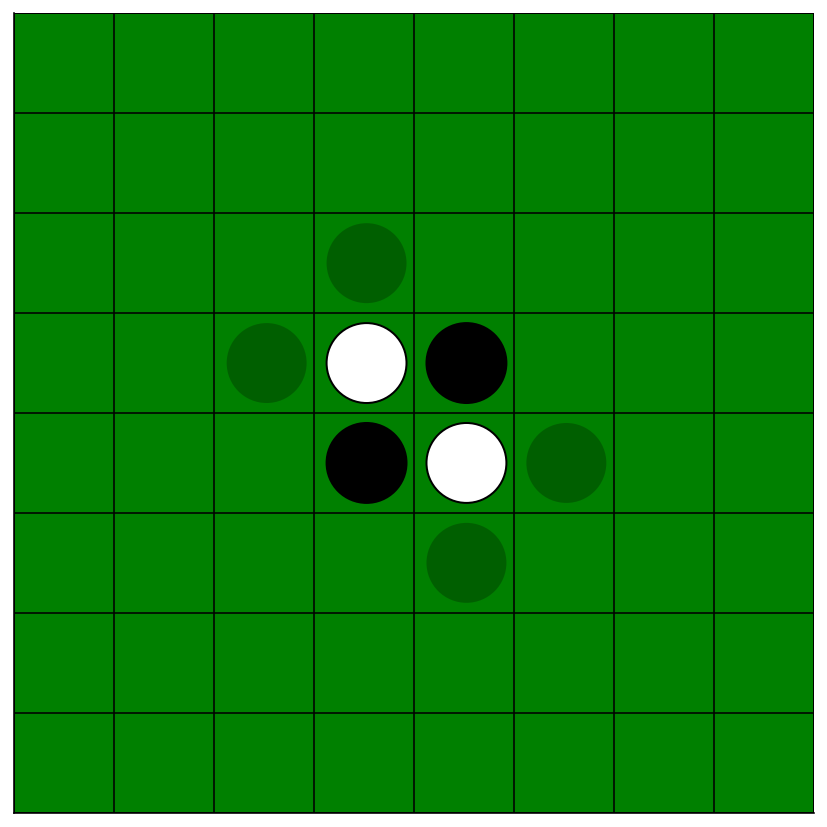

<IPython.core.display.Javascript object>

In [10]:
interface = InteractiveOthelloGame(n=8)
interface.next_turn()

To solve Othello with reinforcement learning, we can formulate it as a Markov decision process. The set of states consists of all possible board configurations, and the set of actions consists of all positions on the board. The game admits a deterministic transition function from one state to another, connected by a legal move. How did we define the reward function for AlphaZero? Is the reward issued at every time step? Do players receive the same reward?

In [11]:
reward_function = "Rewards are determined at the end of the game; the winner receives +1, the loser -1, and both players receive 0 reward in the event of a draw." #@param {type:"string"}

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/reward_function.md)

## Value and Policy

In week 1, we learned AlphaZero from bottom-up, building intuitions that eventually led to the full algorithm. This time let's start with the big picture. AlphaZero is a deep reinforcement learning algorithm that uses a deep neural net to provide heuristics for Monte-Carlo Tree Search (MCTS). We will go over MCTS in a bit, but let's first look at the deep learning components of AlphaZero.

At the core of Alphazero is a convolutional neural network $f_{\theta}$ with two heads: a value head and a policy head. The network takes an $n\times n$ board state as input and outputs two things: a value of the board state $v_{\theta}(s) \in [-1, 1]$ and a policy $\mathbf{p}_{\theta}(s)$, which is a probability vector over actions. The value estimates the expected outcome of the board state, and the policy mimics the normalized visit counts of all actions collected by MCTS. Formally, given a state $s$, its expected outcome $z$ and a vector of normalized visit counts $\mathbf{\pi}$, the network is trained to minimize a sum of MSE loss and cross-entropy loss: $$\ell = (z - v_{\theta}(s))^2 - \mathbf{\pi}^\top \log \mathbf{p}_{\theta}(s) + c\|\theta\|^2$$ where $c$ controls the weight of L2 regularization. Note that unlike in actor-critic algorithms where the policy is used for inference and the value networks guides policy training, here both the policy and the value are auxiliary to MCTS. We will see in the next part how the policy and the value are used. In inference time, we run MCTS for a fixed number of iterations and normalize the actual visit counts to get the policy.

In [14]:
class PolicyValueNet(nn.Module):
    """This is a single neural network with two outputs: one "policy" output and
    one "value" output. It has two "heads" that share the same "body".
    """
    def __init__(self, num_channels=64, n=8, dropout=0.3):
        super(PolicyValueNet, self).__init__()
        
        # game params
        self.n = n
        self.dropout = dropout
        self.action_size = self.n*self.n
        self.num_channels = num_channels

        # Shared body: two conv layers followed by 2 fully connected layers
        self.conv1 = nn.Conv2d(1, num_channels, 3)
        self.conv2 = nn.Conv2d(num_channels, num_channels*2, 3)
        self.fc1 = nn.Linear(num_channels*2*(self.n-4)*(self.n-4), num_channels*2)
        self.fc2 = nn.Linear(num_channels*2, num_channels)

        # Value head: one more linear layer after fc2
        self.val_fc = nn.Linear(num_channels, 1)

        # Policy head: linear from fc2 to action_size
        self.pol_fc = nn.Linear(num_channels, self.action_size)

    def forward(self, s):
        # Body
        s = s.view(-1, 1, self.n, self.n)
        s = F.dropout2d(F.relu(self.conv1(s)), p=self.dropout, training=self.training)
        s = F.dropout2d(F.relu(self.conv2(s)), p=self.dropout, training=self.training)
        s = s.view(-1, self.num_channels*2*(self.n-4)*(self.n-4))
        s = F.dropout(F.relu(self.fc1(s)), p=self.dropout, training=self.training)
        s = F.dropout(F.relu(self.fc2(s)), p=self.dropout, training=self.training)
        
        # Value head
        v = torch.tanh(self.val_fc(s))
        
        # Policy head
        p = F.log_softmax(self.pol_fc(s), dim=1)

        return p, v

## Monte-Carlo Tree Search (MCTS)

AlphaZero uses Monte-Carlo Tree search to improve its policy estimates and to generate the final policy. Recall that in an MCTS tree, each node corresponds to a board state, and each edge represents a transition by a valid move. An edge maintains three attributes: the expected reward for taking the action $Q(s, a)$, the number of times this edge has been visited $N(s, a)$, and the number of times the node has been visited $N(s)$. By now, you should be much more comfortable with the meaning of Q-value than you were back in week 1.

Let's review the tree-growing procedure in more detail. In the beginning of each game, we start with an empty tree. In each turn, we grow the tree by a fixed number of nodes using MCTS. Specifically, each node is grown by starting from current state $s_t$ and taking actions that maximize the upper confidence bound (UCB) until a new leaf is grown. If this new leaf corresponds to a terminal state, then we take its reward and propagate all the way down to the root. Otherwise we bootstrap a value estimate of the new leaf state from the neural network and do the same propagation. By propagation, we mean that for each edge $(s, a)$ along the path, set $Q(s, a) = \frac{Q(s, a) * N(s, a) + v}{N(s, a) + 1}$, where $v$ is the reward or the value of the leaf state. Note that this is the only place where we use the value network $v_{\theta}$. Finally, having performed a number of searches in a turn, the statistics at $s_t$ provides a good estimate of the optimial policy. We sample an action from the normalized visit counts to take in this turn: $\pi(a) = \frac{N(s, a)}{N(s)}$.

In [13]:
# @markdown Which concept does using a value estimate for the last state relate to?
value_estimate = " N-step TD learning" # @param {type:"string"}

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/value_estimate_T2.md)

What remains to be specified is the upper confidence bound (UCB). The UCB takes the following form: 

$$U(s,a)=Q(s,a) + c_{puct} P(s,a)\frac{\sqrt{N(s)}}{1+N(s,a)}$$

In this expression, $P(s, a)$ is the policy output by the neural network. The first term favors actions with high values. The second term favors actions that are less visited but good according to the policy. $c_{puct}$ balances exploitation and exploration.

In [15]:
#@markdown What happens if we set c_puct too high? What about too low?
c_puct = " High c_puct favors exploration, so the agent might not ever employ the best moves it has learned, whereas with a low c_puct, it may only employ the moves it has learned but never improve on them." # @param {type:"string"}

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/c_puct.md)

In [16]:
#@markdown MCTSTree class
import plotly.graph_objs as go
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

class MCTSTree(object):
    """Monte Carlo Tree Search. An MCTS object is initialized with a policy and
    value function.

    Search behavior is controlled using num_search (number of searches to run)
    and cpuct (explore/exploit hyperparameter)

    Based partially on github.com/suragnair/alpha-zero-general/
    """

    def __init__(self, policy_value_fun, n_games=1, n=8, num_search=100, cpuct:float=1.0):
        assert cpuct > 0, "cpuct parameter must be positive"
        assert num_search >= 1, "Must have >=1 simulation"
        self.pol_val_fun = policy_value_fun
        self.num_search = num_search
        self.cpuct = cpuct
        self.max_depth = 500
        self.n_games = n_games
        self.n = n
        self.init_tree()

        if self.n_games > 1 and self.__class__.__name__ == "MCTSTree":
            raise ValueError("The base MCTSTree class can only handle one game at a time!")
    
    def init_tree(self):
        # s refers to state, a to actions. States are used as dictionary keys
        # by calling state_key on single games.
        self.Ns = {}  # stores #times state s was visited
        self.Ls = {}  # stores list of legal moves at state s
        self.Ps = {}  # stores snap policy judgment at s: tensor same size as Ls
        self.Vs = {}  # stores snap value judgment at s: scalar tensor
        self.Tsa = {} # stores total sub-tree values for s: tensor same size as Ls where index i corresponds to Ls[s][i]
        self.Nsa = {} # stores #times edge s,a was visited: same format as Tsa
        # For debugging/visualization...
        self.Ksa = {} # stores a set of (action, child_idx) tuples from each parent node
        self.Bs = {} # stores board state as a tuple of integers for plotting
    
    def state_key(self, game:OthelloGame, player):
        # get_uid returns a [n_games] tensor of int64 hashes. Assume n_games=1
        # and grab the int out of the tensor.
        return game.get_uid(player).item()

    def count_child_visits(self, game):
        """Return visit count for children of the given game
        """
        s = self.state_key(game, game.current_player)
        counts = torch.zeros_like(game.boards)
        children = self.Ls[s]
        for k, (i,j) in enumerate(children):
            counts[0,i,j] = self.Nsa[s][k]
        return counts
    
    def run_searches(self, game):
        """Run self.num_searches searches from the given game position, extending
        whatever tree we already have.

        Note: nothing is returned, since the effect of this function is to
        expand the tree which is stored as instance variables.
        """
        for i in range(self.num_search):
            state = game.copy_state()
            self.single_search(game)
            game.paste_state(state)

    def single_search(self, game:OthelloGame):
        """This function performs one iteration of MCTS. It loops until a leaf 
        state (unvisited or end of game) is found. The action chosen at each
        step is one that has the maximum upper confidence bound (UCB).

        Note: nothing is returned, since the effect of this function is to
        expand the tree which is stored as instance variables.

        After returning, assume 'game' is irreversible altered. The caller is
        responsible for copying the game state as needed. (See @run_searches)
        """
        path = []
        for d in range(self.max_depth):
            s = self.state_key(game, game.current_player)

            # Record board position for plotting
            if s not in self.Bs:
                self.Bs[s] = tuple(int(v) for v in game.boards[0].flatten().cpu())
            
            # Count visit to this state
            self.Ns[s] = 1 if s not in self.Ns else self.Ns[s]+1

            is_unvisited = self.Ns[s] == 1
            is_leaf = is_unvisited or game.game_status == OthelloGame.OVER
            if is_leaf:
                # Found a leaf! Get ready to propagate value back through the
                # search path.
                if is_unvisited:
                    if game.game_status == OthelloGame.OVER:
                        # No guesswork on the value. Use the actual game outcome.
                        result = game.score_games()[0]
                        self.Vs[s] = result[0] if game.current_player == OthelloGame.PLAYER1 else result[1]
                    else:
                        # This is a *new* leaf. Run policy and value on this state.
                        pol, self.Vs[s] = self.pol_val_fun(game.boards, game.current_player)
                        self.Ls[s] = game.get_available_actions()[0]
                        # Store snap-policy judgment just over legal moves
                        self.Ps[s] = torch.tensor([pol[0,i,j] for (i,j) in self.Ls[s]])
                        # Initialize empty child counts from s
                        self.Nsa[s] = torch.zeros(len(self.Ls[s]))
                        self.Tsa[s] = torch.zeros(len(self.Ls[s]))
                # Note: value Vs[s] is from the perspective of the player whos
                # turn it is in state s, *not* from the perspective of whoever
                # just played a turn before.
                backup_value = self.Vs[s]
                break
            else:
                # We've been here before. Select next move according to UCB.
                legal_actions = self.Ls[s]
                if len(legal_actions) == 0:
                    next_action_idx, next_action = None, OthelloGame.PASS
                else:
                    # Q-value is average value = total value / number of visits
                    Qsa = self.Tsa[s] / self.Nsa[s]
                    # Wherever Nsa==0, set Q to (otherwise it is nan)
                    Qsa[self.Nsa[s] == 0] = 0.0
                    # UCB is a combination of Q values and snap-judgment policy.
                    # Note: for UCB purposes, this visit isn't complete yet, so subtract 1 from Ns
                    UCB = Qsa + self.cpuct * self.Ps[s] * math.sqrt(self.Ns[s] - 1) / (1 + self.Nsa[s])
                    # Argmax the UCB score for next action
                    next_action_idx = torch.argmax(UCB).item()
                    next_action = self.Ls[s][next_action_idx]
                
                # Book-keeping: keep track of all (s,a) pairs along the search path
                path.append((s, next_action_idx))

                # Advance to the next state
                game.step(next_action)
                
                # Store parent id -> (action, child id) map
                if next_action_idx is not None:
                    if s not in self.Ksa:
                        self.Ksa[s] = set()
                    self.Ksa[s].add((next_action, self.state_key(game, game.current_player)))
        else:
            # For...else syntax should be read as "no break" clause. We land
            # here if no leaf was ever encountered.
            raise RuntimeError("Never hit a leaf! This shouldn't happen!")
        
        # print("[DEBUG] ENDED SEARCH AT", s)
        # print("[DEBUG] PATH WAS", path)
        
        # Run back through the path updating states. Recall that values are always
        # from the perspective of whoever's turn it is when the board was evaluated.
        # Since player 1's gains are necessarily player 2's losses (AKA minimax),
        # we have to flip the sign of the value for each step back up the tree.
        while len(path) > 0:
            backup_value = -backup_value
            s, action_idx = path.pop()
            # print("[DEBUG] BACKUP", s, action_idx, self.Ls[s][action_idx])
            # print("[DEBUG] VALUE", backup_value)
            if action_idx is not None:
                self.Nsa[s][action_idx] = self.Nsa[s][action_idx] + 1
                self.Tsa[s][action_idx] = self.Tsa[s][action_idx] + backup_value
    
    def to_graph(self, game:OthelloGame, g_idx=0, max_depth:int=100):
        """Debugging helper. Retuns a networkx.DiGraph representation of the tree.
        """
        root = self.state_key(game, game.current_player)
        G = nx.DiGraph()
        G.add_node(root,
                player=game.current_player,
                value=self.Vs[root].item(),
                # hash=root, # for debugging only
                n=self.Ns[root])
        # queue contains tuples of (parent uid, child idx, child uid, depth, player)
        queue = [(root, act, ch, 1, 3-game.current_player) for act, ch in self.Ksa[root]]
        while len(queue) > 0:
            parent, act, child, depth, player = queue.pop()
            idx = [i for i in range(len(self.Ls[parent])) if self.Ls[parent][i] == act][0]
            G.add_node(child,
                    player=player,
                    value=self.Vs[child].item(),
                    # hash=child, # for debugging only
                    visits=self.Ns[child])
            G.add_edge(parent, child,
                    policy=self.Ps[parent][idx].item(),
                    visits=self.Nsa[parent][idx].item(),
                    q=self.Tsa[parent][idx].item()/self.Nsa[parent][idx].item(),
                    action=act)
            if depth < max_depth and child in self.Ksa:
                queue.extend([(child, a, ch, depth+1, 3-player) for a, ch in self.Ksa[child]])
        return G, root


In [17]:
#@markdown CUDA helper kernel

@cuda.jit
def cuda_index_of(values, table_entries, table_lengths, indices, add_new):
    """Naive linear search to find the index(es) of the given value(es). Runs in
    parallel: multiple tables and values can be searched at once. Results are
    stored in 'indices'. If add_new=True and an item isn't found, it is appended
    to the table and the new index is returned. If add_new=False, then -1 is used
    to mean 'not found'.

    Uses block indexing, so call with cuda_index_of[num_tables,1](...)
    """
    bx = cuda.blockIdx.x
    max_search = table_lengths[bx]
    val = values[bx]

    for i in range(max_search):
        if table_entries[bx, i] == val:
            indices[bx] = i
            return

    # Not found! either add a new entry or return -1
    if add_new:
        table_entries[bx, max_search] = val
        table_lengths[bx] = table_lengths[bx] + 1
        indices[bx] = max_search
    else:
        indices[bx] = -1

def test_cuda_index_of():
    table = torch.zeros(2, 10, dtype=torch.int64, device='cuda')
    hashes = torch.zeros(2, dtype=torch.int64, device='cuda')
    lengths = torch.zeros(2, dtype=torch.int32, device='cuda')
    indices = torch.zeros(2, dtype=torch.int32, device='cuda')

    hashes[0] = 42
    hashes[1] = 101

    # Empty table --> results should have index -1 and table and lengths should be unchanged
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), False)
    assert torch.all(indices == -1)
    assert torch.all(lengths == 0)
    assert torch.all(table == 0)

    # Same inputs except now add_new=True. Indices should be 0 (1st element) and
    # table and lengths should be updated
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), True)
    assert torch.all(indices == 0)
    assert torch.all(lengths == 1)
    assert torch.all(table[:,0] == hashes)
    assert torch.all(table[:,1:] == 0)

    # add_new a second time with same inputs --> no effect
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), True)
    assert torch.all(indices == 0)
    assert torch.all(lengths == 1)
    assert torch.all(table[:,0] == hashes)
    assert torch.all(table[:,1:] == 0)

    # Another round of new values, add_new=False
    hashes[0] = 11
    hashes[1] = 2021
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), False)
    assert torch.all(indices == -1)
    assert torch.all(lengths == 1)
    assert torch.all(table[:,0] == torch.as_tensor([42, 101], device='cuda'))
    assert torch.all(table[:,1:] == 0)

    # Another round of new values, add_new=True
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), True)
    assert torch.all(indices == 1)
    assert torch.all(lengths == 2)
    assert torch.all(table[:,0] == torch.as_tensor([42, 101], device='cuda'))
    assert torch.all(table[:,1] == torch.as_tensor([11, 2021], device='cuda'))
    assert torch.all(table[:,2:] == 0)

    # add_new again --> no effect
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), True)
    assert torch.all(indices == 1)
    assert torch.all(lengths == 2)
    assert torch.all(table[:,0] == torch.as_tensor([42, 101], device='cuda'))
    assert torch.all(table[:,1] == torch.as_tensor([11, 2021], device='cuda'))
    assert torch.all(table[:,2:] == 0)

    # One new one old, add_new=False
    hashes[0] = 12345
    hashes[1] = 101
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), False)
    assert torch.all(indices == torch.as_tensor([-1, 0], device='cuda'))
    assert torch.all(lengths == torch.as_tensor([2, 2], device='cuda'))
    assert torch.all(table[:,:2] == torch.as_tensor([[42,11],[101,2021]], device='cuda'))
    assert torch.all(table[:,2:] == 0)

    # One new one old, add_new=True
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), True)
    assert torch.all(indices == torch.as_tensor([2, 0], device='cuda'))
    assert torch.all(lengths == torch.as_tensor([3, 2], device='cuda'))
    assert torch.all(table[:,:3] == torch.as_tensor([[42,11,12345],[101,2021,0]], device='cuda'))
    assert torch.all(table[:,3:] == 0)

    # add_new again --> no effect
    cuda_index_of[2,1](torch2cuda(hashes), torch2cuda(table), torch2cuda(lengths), torch2cuda(indices), True)
    assert torch.all(indices == torch.as_tensor([2, 0], device='cuda'))
    assert torch.all(lengths == torch.as_tensor([3, 2], device='cuda'))
    assert torch.all(table[:,:3] == torch.as_tensor([[42,11,12345],[101,2021,0]], device='cuda'))
    assert torch.all(table[:,3:] == 0)

    print("TEST PASSED")

test_cuda_index_of()

TEST PASSED


In [18]:
#@markdown ParallelMCTSTree class
class ParallelMCTSTree(MCTSTree):
    """Same function as MCTSTree, but parallelized over games, and searches
    live entirely on the GPU so there is no GPU<->CPU transfer bottleneck.

    policy_value_fun must also be able to accept and return entirely GPU tensors.

    Overrides init_tree, count_child_visits, single_search, to_graph, and
    state_key, but inherits run_searches and is otherwise functionally identical
    """
    INITIAL_TREE_SIZE = 256

    def __init__(self, *args, **kwargs):
        if 'debug' in kwargs:
            self._debug = kwargs['debug']
            del kwargs['debug']
        else:
            self._debug = False
        super(ParallelMCTSTree, self).__init__(*args, **kwargs)
        # Helper for slicing into the n_games dimension, since writing
        # torch.arange(self.n_games) over and over again is ugly.
        self._g_idx = torch.arange(self.n_games)
    
    def state_key(self, game:OthelloGame, player):
        # Whereas MCTSTree returns the .item() of a single game hash, here
        # we want all of them. Calling get_uid with out=self.cur_hash deposits
        # the result in the memory already owned by self.cur_hash and
        # self._cuda_cur_hash. The 'return' is redundant; it returns self.cur_hash
        # A call to _set_idx_to_hash(...) is still required to line up cur_idx
        # with cur_hash!
        return game.get_uid(player, out=self.cur_hash)
    
    def _set_idx_to_hash(self, add_new):
        """Set self.cur_idx to the index in the lookup_hash table that matches
        self.cur_hash. If add_new is True, creates a new table entry for unseen
        hashes. If add_new is false, then cur_idx will be -1 if unseen.
        """
        cuda_index_of[self.n_games, 1](self._cuda_cur_hash,
                                       self._cuda_lookup_hash,
                                       self._cuda_num_nodes,
                                       self._cuda_cur_idx,
                                       add_new)

    def init_tree(self):
        """Override MCTSTree.init_tree. Rather than python dicts, we do all
        tree book-keeping using GPU tensors.

        The idea is to pre-allocate space for a small-ish tree. As we search, if
        the data structures for the tree fill up, we double its allocated space
        and copy data over (see _expand_tree and _expand_tree_if_full)
        """
        # Clear the GPU memory before trying to allocate big tensors. Otherwise,
        # GPU memory fills up and we get esoteric error messages about "CUDA
        # device-side assertion failure"
        torch.cuda.empty_cache()
        # Allocate a tree with space for INITIAL_TREE_SIZE nodes. During search,
        # we will expand the memory as needed.
        self._tree_size = ParallelMCTSTree.INITIAL_TREE_SIZE
        self.Ns  = torch.zeros(self.n_games, self._tree_size, dtype=torch.float32, device='cuda') # One count per game per node
        self.Vs  = torch.zeros(self.n_games, self._tree_size, dtype=torch.float32, device='cuda') # One value per game per node
        self.Ps  = torch.zeros(self.n_games, self._tree_size, self.n, self.n, dtype=torch.float32, device='cuda') # Per-game, per-node, snap judgment policy output
        self.Tsa = torch.zeros(self.n_games, self._tree_size, self.n, self.n, dtype=torch.float32, device='cuda') # Per-game, per-node, per-position, sum of sub-tree values
        self.Nsa = torch.zeros(self.n_games, self._tree_size, self.n, self.n, dtype=torch.int32, device='cuda') # Per-game, per-node, per-position, visit counts
        self.lookup_hash = torch.zeros(self.n_games, self._tree_size, dtype=torch.int64, device='cuda') # Lookup table of board hashes
        self.cur_hash = torch.zeros(self.n_games, dtype=torch.int64, device='cuda') # Helper during search: current hash
        self.cur_idx = torch.zeros(self.n_games, dtype=torch.int64, device='cuda') # Helper during search: current index corresponding to cur_hash
        self.num_nodes = torch.zeros(self.n_games, dtype=torch.int32, device='cuda') # How many nodes we have so far to cap the search through lookup_hash
        if self._debug:
            # Only while in debug mode: keep a dictionary of parent->child UIDs
            # just like in the MCTSTree parent class. This requires GPU->CPU
            # data transfer so it is disabled by default. But it is necessary
            # for to_graph().
            self.Ksa = {}
            # Also keep a record of uid -> board state for visualization
            self.Bs = {}

        # Make _cuda_X wrappers around variables involved in hash lookups
        to_wrap = ['lookup_hash', 'cur_hash', 'cur_idx', 'num_nodes']
        for var in to_wrap:
            self.__dict__['_cuda_' + var] = torch2cuda(self.__dict__[var])
    
    def _expand_tree_if_full(self):
        buffer = 2 # Give some wiggle room just in case
        if self.num_nodes.max() >= self._tree_size - buffer:
            self._expand_tree()
    
    def _expand_tree(self):
        # print(f"[DEBUG] resizing tree from {self._tree_size} to {self._tree_size*2}")
        old_size = self._tree_size
        self._tree_size *= 2

        # Make a copy of each of the to_copy variables, expanding them along
        # dimension 1 to twice their previous size.
        to_copy = ['Ns', 'Vs', 'Ps', 'Tsa', 'Nsa', 'lookup_hash']
        for var in to_copy:
            old_tensor = self.__dict__[var]
            sz = list(old_tensor.size())
            assert sz[1] == old_size, f"Expected {var} to have dimension 1 size {self._tree_size} but was {sz[1]}. What gives?"
            sz[1] = self._tree_size
            new_tensor = torch.zeros(tuple(sz), dtype=old_tensor.dtype, device=old_tensor.device)
            new_tensor[:, :old_size, ...] = old_tensor
            self.__dict__[var] = new_tensor
        
        # Note we didn't touch cur_hash, cur_idx, or num_nodes so those can stay as they were
        to_wrap = ['lookup_hash']
        for var in to_wrap:
            self.__dict__['_cuda_' + var] = torch2cuda(self.__dict__[var])
    
    def count_child_visits(self, game:OthelloGame) -> torch.Tensor:
        # First, get the hash and index of the given game
        self.state_key(game, game.current_player)
        self._set_idx_to_hash(add_new=False)
        # Sanity check that all states do in fact exist in the table
        if torch.any(self.cur_idx == -1):
            raise ValueError("Failed to find a node! This shouldn't happen!")
        # Once index_of completes, we have the index into the nodes table per
        # game stored in self.cur_idx
        return self.Nsa[self._g_idx, self.cur_idx, :, :]

    def single_search(self, game:OthelloGame):
        # Path logs the (state, action) pairs along search paths. State is a
        # copy of cur_idx, and action is a [n_games,2] tensor. Both live on GPU.
        path = []

        # Each search (probably) adds a node. Expand the tree's memory if it's
        # close to filling up
        self._expand_tree_if_full()

        # Keep selecting moves until every game hits a leaf. We flag a game as
        # being at a leaf by setting game_status=OVER, even though it might not
        # really be over.

        # Pre-allocate actions tensor (init to zero so the did_pass test is
        # False on the 1st loop iteration)
        actions = torch.zeros(self.n_games, 2, dtype=torch.int32, device='cuda')
        # Pre-allocate boolean mask indicating which games need "expansion" aka
        # need the policy_value_function to be called on them. We don't expand
        # end-of-game states after their first visit.
        needs_expansion = torch.zeros(self.n_games, dtype=torch.bool, device='cuda')
        # Keep track of which game states are OVER for real (because leaf states
        # are flagged as OVER without really being over)
        is_terminal = torch.zeros(self.n_games, dtype=torch.bool, device='cuda')
        # Different games may hit leaves at different times, meaning they may
        # have different 'current_player' values! leaf_player keeps track of who
        # 'current_player' was each time we hit a leaf. Note: if player A plays
        # a move that results in a novel state (a leaf), then leaf_player will
        # be player B because that's whose turn it is _in the state being
        # evaluated_. So leaf_player is set to player B. Similarly, if player A
        # plays the final PASS move that ends the game, then player B is again 
        # the leaf_player.
        leaf_player = torch.zeros(self.n_games, dtype=torch.int64, device='cuda')
        depth = 0
        while depth < self.max_depth and torch.any(leaf_player == 0):
            depth += 1

            # Compute hashes for each game's current state -> result stored in
            # self.cur_hash. 
            self.state_key(game, game.current_player)
            # Lookup node index by hash -> result stored in self.cur_idx. Set
            # add_new to True to add this state to the table if it didn't
            # already exist
            self._set_idx_to_hash(add_new=True)
            # print(f"[DEBUG] Depth {depth} hash {self.cur_hash.cpu().numpy()}")
            # print(f"[DEBUG] Depth {depth} index {self.cur_idx.cpu().numpy()}")

            # print("[DEBUG]" + str(depth) + "  "*depth + f"TREE SIZE {self.num_nodes.max().item()}/{self._tree_size}; INDEX {self.cur_idx.max().item()}")
            if self.cur_idx.max() >= self._tree_size-1:
                raise RuntimeError("TREE IS FULL! This should not happen!")

            # Book-keeping for plotting
            if self._debug:
                for g in range(self.n_games):
                    s = self.cur_hash[g].item()
                    self.Bs[s] = tuple(game.boards[g].cpu().int().flatten().numpy())

            #########################
            ### DETECT NEW LEAVES ###
            #########################

            # Did we hit any new leaves? If so, mark them as leaves that need
            # expanding. (This does apply to end-of-game states that we're
            # seeing for the first time)
            needs_expansion = needs_expansion | (self.Ns[self._g_idx, self.cur_idx] == 0)
            # We can tell that this leaf was *just* encountered because it will
            # being the state of both needs_expansion but also ACTIVE. Record
            # who the player is at the time of encountering this leaf.
            is_new_leaf = needs_expansion & (game.game_status == OthelloGame.ACTIVE)
            # Flag all new leaves as OVER to freeze their board state.
            game.game_status[is_new_leaf] = OthelloGame.OVER
            # Record leaf_player: whose turn is it *now* ("player B" in the
            # comments above)
            leaf_player[is_new_leaf] = game.current_player

            # Detect games that *just* ended and store whose turn it is *now*
            # ("player B" in above comments)
            just_ended = (game.game_status == OthelloGame.OVER) & (leaf_player == 0)
            # Mark this game as in a "terminal" state
            is_terminal = is_terminal | just_ended
            # Record whose turn it is
            leaf_player[just_ended] = game.current_player

            ########################
            ### INCREMENT VISITS ###
            ########################

            # Increment visit count unless the previous move was a PASS, in which
            # case we're seeing the same state over and over again but it is not
            # a new visit.
            did_pass = actions[:,0] == -1
            self.Ns[self._g_idx[~did_pass], self.cur_idx[~did_pass]] = \
                self.Ns[self._g_idx[~did_pass], self.cur_idx[~did_pass]] + 1

            # We can skip the rest of the loop if everything is done. This is
            # important to ensure that path.append() was called exactly as many
            # times as game.step().
            if torch.all(game.game_status == OthelloGame.OVER):
                # print(f"[DEBUG] BREAKING on {depth}")
                break

            ############################
            ### UCB ACTION SELECTION ###
            ############################
            
            # For all non-leaf games, select another move using max of UCB.
            T = self.Tsa[self._g_idx, self.cur_idx, ...]
            N = self.Nsa[self._g_idx, self.cur_idx, ...]
            P = self.Ps[self._g_idx, self.cur_idx, ...]
            Ntot = self.Ns[self._g_idx, self.cur_idx].view(self.n_games,1,1) - 1 # For UCB purposes, this visit isn't complete yet, so subtract 1
            # Q-value is average value = total value / number of visits, or zero
            # if the (s,a) pair has not yet been tried. Shape is [n_games, n, n]
            Q = T/N
            Q[N==0] = 0
            # UCB is a combination of Q values and snap-judgment policy. Shape
            # is [n_games, n, n]
            UCB = Q + self.cpuct * P * torch.sqrt(Ntot) / (1 + N)
            UCB.masked_fill_(game._valid_moves == 0, float('-inf'))
            # Argmax the UCB score for next action
            next_action_flat_idx = torch.argmax(UCB.view(self.n_games, -1), dim=1)
            actions[:,0], actions[:,1] = next_action_flat_idx // self.n, next_action_flat_idx % self.n

            # Pass if there were no moves available or if the game is OVER. This
            # includes games that are flagged as leaves.
            do_pass = torch.all(game._valid_moves.view(self.n_games, -1) == 0, dim=1) | (game.game_status == OthelloGame.OVER)
            actions[do_pass, :] = -1

            ##############################
            ### RECORD ACTION AND STEP ###
            ##############################
            
            # Book-keeping: keep track of all (state idx, action) tuples along
            # the search path so we can back-up values later.
            path.append((self.cur_idx.clone(), actions.clone()))

            if self._debug:
                # If in debug mode, make a copy of the 'parent' hash value
                parent_hash = self.cur_hash.cpu().numpy()

            # print(f"[DEBUG] Depth {depth} actions are {actions.cpu().numpy()}")

            # Advance to the next state.
            game.step(actions)

            # When in debug mode, keep track of set of parent->child hashes
            if self._debug:
                child_hash = game.get_uid().cpu().numpy()
                actions_copy = actions.cpu().int().numpy()
                # Record parent hash -> set of tuples of (action, child hashes)
                for g in range(self.n_games):
                    s = self.cur_hash[g].item()
                    # Get action as a tuple of (row,col) integers
                    act = tuple(actions_copy[g,:].flatten())
                    if do_pass[g]:
                        continue
                    elif parent_hash[g] in self.Ksa:
                        self.Ksa[s].add((act, child_hash[g]))
                    else:
                        self.Ksa[s] = {(act, child_hash[g])}

        # After loop: ensure hashes and indices are up to date with game states.
        # Importantly, state_key depends on who the player is. Make sure all
        # hashes are relative to the leaf_player!
        self.state_key(game, leaf_player)
        self._set_idx_to_hash(add_new=True)
        # print(f"[DEBUG] After loop, hashes are {self.cur_hash}")
        # print(f"[DEBUG] ...and indices are {self.cur_idx}")

        # Sanity check that there is a leaf_player for all games
        # print(f"[DEBUG] leaf_player = {leaf_player.cpu().numpy()}")
        assert torch.all(leaf_player > 0), "Missing leaf player! This shouldn't happen!"

        # Prepare back-up values, which will all be from the perspective of
        # 'leaf_player'. Begin with the final-outcome value which will be used
        # for terminal states.
        backup_value = game.score_games()[self._g_idx, leaf_player-1].float()
        
        # "Expand" states that are being visited for the first time. This means
        # calling the policy+value function.
        needs_expansion = needs_expansion & ~is_terminal # don't bother expanding terminal states
        if torch.any(needs_expansion):
            pol_expansion, val_expansion = self.pol_val_fun(game.boards[needs_expansion, ...], leaf_player[needs_expansion])

            # Store new expansion results
            self.Vs[self._g_idx[needs_expansion], self.cur_idx[needs_expansion]] = val_expansion
            self.Ps[self._g_idx[needs_expansion], self.cur_idx[needs_expansion], ...] = pol_expansion
            
            # Use estimated value for expanded states (note that terminal
            # states' values are left unchanged)
            backup_value[needs_expansion] = val_expansion

        # Which player did we end on? Note leaf_player may be different for
        # each game, but backup assumes all values are w.r.t. the current player.
        # We address this by flipping all value signs wherever leaf_player is
        # not equal to the current_player. The backup routine does not
        # record values for PASS moves, and all games that hit a leaf early on
        # were padded with PASS actions. By aligning all the values to the
        # perspective of the "current_player", the backup is synchronized to
        # the same player perspective across all games. This works becaues all
        # games will go through the same number of backup steps; those that hit
        # a leaf early will simply back-up through multiple PASSes, which has
        # no effect.
        backup_value[game.current_player != leaf_player] = -backup_value[game.current_player != leaf_player]

        # Run back through the path updating states. Recall that values are always
        # from the perspective of whoever's turn it is when the board was evaluated.
        # Since player 1's gains are necessarily player 2's losses (AKA minimax),
        # we have to flip the sign of the value for each step back up the tree.
        while len(path) > 0:
            node_idx, action = path.pop()
            act_i, act_j = action[:,0].long(), action[:,1].long()
            valid = act_i != -1 # Don't back up anything through pass actions
            key = (self._g_idx[valid], node_idx[valid], act_i[valid], act_j[valid])
            
            # Calling pop() moved us one step back in time. Flip perspective.
            backup_value = -backup_value

            # Increment visit count at (state, action) pair if not pass
            self.Nsa[key] = self.Nsa[key] + 1

            # Count total value if not pass
            self.Tsa[key] = self.Tsa[key] + backup_value[valid]
    
    def to_graph(self, game:OthelloGame, g_idx=0, max_depth:int=100):
        """Debugging helper. Retuns a networkx.DiGraph representation of the
        tree containing useful info in the node and edge attributes.
        """
        if not self._debug:
            raise RuntimeError("Cannot vall to_graph if _debug is False!")
        root = self.state_key(game, game.current_player)[g_idx].item()
        self._set_idx_to_hash(add_new=False)
        G = nx.DiGraph()
        G.add_node(root,
                player=game.current_player,
                value=self.Vs[g_idx, self.cur_idx[g_idx]].item(),
                visits=self.Ns[g_idx, self.cur_idx[g_idx]])
        # queue contains tuples of (parent uid, child idx, child uid, depth, player)
        queue = [(root, act, ch, 1, 3-game.current_player) for act, ch in self.Ksa[root]]
        while len(queue) > 0:
            parent, act, child, depth, player = queue.pop()
            self.cur_hash[:] = child
            self._set_idx_to_hash(add_new=False)
            if self.cur_idx[g_idx] == -1:
                # Child not found (must be terminal)
                continue
            G.add_node(child,
                    player=player,
                    value=self.Vs[g_idx, self.cur_idx[g_idx]].item(),
                    visits=self.Ns[g_idx, self.cur_idx[g_idx]].item())
            child_idx = torch.where(self.lookup_hash[g_idx, ...] == child)[0].cpu().item()
            G.add_edge(parent, child,
                       action=act,
                       policy=self.Ps[g_idx, child_idx, act[0], act[1]].item(),
                       visits=self.Ns[g_idx, child_idx].item())
            if depth < max_depth and child in self.Ksa:
                queue.extend([(child, act, ch, depth+1, 3-player) for act, ch in self.Ksa[child]])
        return G, root

In [19]:
#@markdown Base agent
class ArtificialPlayer(object):
    """A base class for agents that play Othello. Sub-classes must provide a
    select_move method which takes in an OthelloGame and returns an action
    (in other words, returns a tuple (row,col) to place a stone or None to pass)
    """
    def __init__(self, name="AI Agent"):
        self.name = name

    def select_move(self, game:OthelloGame):
        raise NotImplementedError("Must subclass with a playing rule")
    
    def new_game(self):
        """Reset agent state. By default, do nothing...
        """
        pass


class PolicyAgentBase(ArtificialPlayer):
    """Base class for game-playing using a policy. Sub-classes need only provide
    a get_policy function.
    """

    def __init__(self, name=None, temperature:float=1.0):
        self.name = self.__class__.__name__ if name is None else name
        self.t = temperature
    
    def get_policy(self, game:OthelloGame) -> torch.Tensor:
        """PolicyAgentBase.get_policy return a distribution over the board
        of "good" moves for the current player. Doesn't need to be normalized
        over even all legal (those are handled by PolicyAgentBase.select_move).

        Warning: Must not modify game state!
        """
        raise NotImplementedError("Must be implemented by sub-class!")

    def get_selected_move_index(self, policy):
        """Takes a 1d flattened policy for each board and outputs the index of
        the action selected, sampling with the appropriate temperature.
        
        Inputs: policy, a (n_games, n_moves) Tensor
        Outputs: choice_idx, a (n_games) Tensor with integers specifying
                 the action selected for each game (i.e. the column of policy)
        """
        if self.t < 1e-6:
            # Super low temperature is treated as greedy
            choice_idx = torch.argmax(policy, dim=1, keepdim=True)
        else:
            choice_idx = torch.multinomial(policy**(1/self.t), num_samples=1)
        return choice_idx    
    
    def select_move(self, game:OthelloGame):
        policy = self.get_policy(game)
        policy = policy * game._valid_moves.to(policy.device)
        flat_policy = policy.view(game.n_games, -1)
        # Place a dummy value into boards that have no legal moves
        no_moves = torch.sum(game._valid_moves.view(game.n_games, -1), dim=1) == 0
        flat_policy[no_moves, 0] = 1

        flat_choice_idx = self.get_selected_move_index(flat_policy)

        # Now we need to take this unrolled index and convert it into the x,y 
        # board position of the selected move
        i_max, j_max = flat_choice_idx // game.n, flat_choice_idx % game.n
        actions_ij = torch.cat([i_max, j_max], dim=1)
        # Pass on all games that had no valid moves
        actions_ij[no_moves, :] = -1
        return actions_ij
    
    def plot_policy(self, game, mask_legal=True):
        with torch.no_grad():
            policy = self.get_policy(game).cpu()
            if mask_legal:
                policy = policy * game._valid_moves.cpu()
            # Normalize it
            policy = policy / torch.sum(policy, dim=(1,2), keepdims=True)

            for g in range(game.n_games):
                plt.figure(figsize=(6,6))
                ax = plt.gca()
                im = plt.imshow(policy[g,:,:])
                plt.xticks([]); plt.yticks([])
                suffix = '(full board)' if not mask_legal else '(legal moves only)'
                plt.title(f'Policy heatmap {suffix}')
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax=cax)
                plt.show()

In [20]:
#@markdown MCTS agent

class MCTSAgent(PolicyAgentBase):
    def __init__(self, tree:MCTSTree, temperature=1.0):
        super(MCTSAgent, self).__init__(temperature=temperature)
        self.tree = tree # you'll need this!
    
    def new_game(self):
        """Reset the tree for new games.
        """
        self.tree.init_tree()

    def get_policy(self, game:OthelloGame) -> torch.Tensor:
        """Input: game, an instance of OthelloGame
                  MCTStree, a built tree with the root as the starting board
         Returns: policy a (n_games, n, n) Tensor. The distribution over the 
                  board of "good" moves for the current player. 
        """
        # Run searches
        self.tree.run_searches(game)
        # The policy is proportional to visit counts of the children
        return self.tree.count_child_visits(game)


def mcts_visits_callback(game:OthelloGame, agents:List[MCTSAgent]):
    """A callback to store visit counts in the MCTS agent's tree.

    Assuming both agents[0] and agents[1] are instances of MCTSAgent.
    """
    player_agent = agents[game.current_player-1]
    return player_agent.tree.count_child_visits(game).clone()
        

## Training AlphaZero
Finally, let's put everything together in the training loop. AlphaZeros is trained by self-play, which means we have one agent play both sides of the game. In each game, we build a new MCTS tree from scratch, but the model parameters persist throughout training. An sketch of the training loop is as follows:
```
Initialize parameters of the policy & value network.
For n epochs:
    Self-play m games (in parallel) using the current network parameters.
    Collect training data: states, outcomes, and visit counts.
    Train agent for k steps using MSE and cross-entropy loss.
```

We see that AlphaZero involves several concepts we are now familiar with: value, Q-value, policy, etc. Discuss with your pod the following questions that are designed to help you better understand AlphaZero. 


In [21]:
#@markdown AlphaZero is in some sense a policy iteration algorithm. How is the policy evaluated, and how is it improved?
policy_iteration = " The policy is evaluated by rolling out the tree and backpropagating the Q-values to the roots." # @param {type:"string"}


[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/policy_iteration.md)

In [22]:
#@markdown Is AlphaZero on-policy or off-policy?
on_off_policy = " On-policy, the tree roll-out depends on the current policy." # @param {type:"string"}

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/on_off_policy.md)

In [23]:
#@markdown Is AlphaZero model-based or model-free?
model = " Model-free." # @param {type:"string"}

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/model.md)

In [24]:
#@markdown Self-play function

def ai_vs_ai(agent1, agent2=None, n_games=1, n=8, randomize_players=False,
             print_result=False, progbar=True, callback=None, del_progbar=False):
    """Pit 2 AI players against each other (or self-play if just 1 given). Return
    end-state values and list of board positions.
    """
    agent1.new_game()
    if agent2 is None:
        agent2 = agent1
    else:
        agent2.new_game()
    game = OthelloGame(n_games=n_games, n=n)
    saved_boards = []
    callback_data = []
    agents = [agent1, agent2]
    if randomize_players:
        agents = [agent2, agent1]
    if progbar:
        # Games rarely go beyond n^2-4 moves since passes are rare
        progress_bar = tqdm(total=game.n**2-4, desc='# moves per game',
                            leave=not del_progbar)
    
    while torch.any(game.game_status == OthelloGame.ACTIVE):
        # Save board state and flag all boards that are done by flooding them with nan
        saved_boards.append(game.boards.clone())
        saved_boards[-1][game.game_status == OthelloGame.OVER, ...] = float('nan')
        
        # Get move by current player
        act = agents[game.current_player-1].select_move(game)
        
        # Do callback after AI decision but before updating sate
        if callback is not None:
            callback_data.append(callback(game, agents))
        
        # Update state
        game.step(act)
        
        # Update progress bar
        if progbar: progress_bar.update(1)
    
    if progbar:
        progress_bar.total = progress_bar.n
        progress_bar.close()
    values = game.score_games()
    if print_result:
        for g in n_games:
            print(f"Game {g+1} of {n_games}:", end="\t")
            if values[0] == 0:
                print("Draw")
            else:
                print(f"{agents[torch.argmax(values)].name} (Player {torch.argmax(values)+1}) is the winner!")
    # Return end-game value according to player 1 and 2, as well as a list of
    # all board states throughout play
    return values, saved_boards, callback_data

In [25]:
#@markdown Helper functions

SYMMETRIES = [lambda x: x,
              lambda x: torch.rot90(x, 1, dims=(1, 2)),
              lambda x: torch.rot90(x, 2, dims=(1, 2)),
              lambda x: torch.rot90(x, 3, dims=(1, 2)),
              lambda x: torch.flip(x, dims=(1,)),
              lambda x: torch.flip(x, dims=(2,)),
              lambda x: torch.transpose(x, 1, 2)]


def boards2nn(board_states) -> torch.Tensor:
    """Canonical preprocessing, taking in a set of boards and outputting NN inputs.
    """
    if isinstance(board_states, list):
        board_states = torch.cat(board_states, dim=0)
    else:
        board_states = board_states.clone() # Copy so we don't affect the original
    # Convert from [0,1,2] to [0,1,-1] (player 2 represented with -1)
    board_states[torch.where(board_states == 2)] = -1
    return board_states


def prepare_alpha_zero_examples(raw_states:List[torch.Tensor], 
                                raw_counts:List[torch.Tensor], 
                                player1_values:torch.Tensor):
    """Convert from ai_vs_ai output to training examples.

    This function performs canonical preprocessing (e.g. +1 is "current player"
    and -1 is "other player"), concatenates things, and adds in all symmetries.
    """
    n_moves = len(raw_states)
    n_games, n, _ = raw_states[0].size()
    # Concatenate and preprocess board states. Result is size [n_games*n_moves,n,n]
    # ordered like [game0turn0, game1turn0, ... gameNturn0, game0turn1, game1turn1, ... ]
    nn_states = boards2nn(raw_states)
    # Repeat values for every turn (player1_values begins as size [n_games])
    values = player1_values.flatten().float().repeat(n_moves)
    # Flip the sign of all boards that were player 2
    turn_number = torch.arange(n_moves)
    player = (turn_number % 2) + 1
    # 'repeat_interleave()' takes inputs [a b c] and repeats them like
    # [a a a ... b b b ... c c c ...]. Not to be confused with 'repeat()' which
    # outputs [a b c a b c a b c ...].
    player = player.repeat_interleave(n_games)
    nn_states[player == 2, ...] = -nn_states[player == 2, ...]
    values[player == 2, ...] = -values[player == 2, ...]
    # Concatenate and normalize all MCTS visit probabilities
    counts = torch.cat(raw_counts, dim=0).reshape(n_moves*n_games, n, n)
    total_visits = counts.sum(dim=2, keepdim=True).sum(dim=1, keepdim=True)
    probs = counts / total_visits
    # It may be the case that not all games ran for n_moves. These are indicated
    # by nan values in the board state (see ai_vs_ai). Also drop states in which
    # there were no legal moves, indicated by probs being nan (from 0/0)
    drop_states = torch.isnan(nn_states[:,0,0]) | torch.isnan(probs[:,0,0])
    train_states = nn_states[~drop_states, ...]
    train_probs  = probs[~drop_states, ...]
    train_values = values[~drop_states]
    # Add all symmetries (increases effective data 8-fold)
    train_states = torch.cat([sym(train_states) for sym in SYMMETRIES], dim=0)
    train_probs  = torch.cat([sym(train_probs) for sym in SYMMETRIES], dim=0)
    train_values = train_values.repeat(len(SYMMETRIES))
    
    return train_states, train_probs, train_values


def MCTSagent_from_net(policy_value_net: PolicyValueNet, n=8, 
                       games_per_iter=128, num_mcts_search=50):
    """A helper function that takes a PolicyValueNet and returns an MCTSAgent
    that uses that network."""

    def pol_val_fn(boards:torch.Tensor, whoami:torch.Tensor):
        """ This helper function creates prepares the boards to give to the network
        and puts the output in the correct shapes. For use inside the MCTS agent."""
        policy_value_net.eval()
        # Standard board to nn preprocessing: player 2 is now -1
        boards_nn = boards2nn(boards)
        # Always evaluate with +1 meaning "myself" and -1 meaning "other player"
        boards_nn[whoami == OthelloGame.PLAYER2, ...] = -boards_nn[whoami == OthelloGame.PLAYER2, ...]
        with torch.no_grad():   # saves on overhead
            log_policy_output, value = policy_value_net(boards_nn)
        policy = torch.exp(log_policy_output).view(-1, n, n)
        return policy, value.flatten()

    tree = ParallelMCTSTree(pol_val_fn, n_games=games_per_iter, n=n,
                            num_search=num_mcts_search)
    agent = MCTSAgent(tree, temperature=1.0)
    return agent


def cross_entropy_loss(target_p, log_q):
    """Computs the cross entropy. Assumes target_p is a normalized distribution
    and log_q is a log normalized distribution (e.g. output of log_softmax)"""
    b = target_p.size()[0]
    plogq = target_p.view(b, -1) * log_q.view(b, -1)
    cross_entropy = -plogq.sum(dim=1)
    return cross_entropy.mean()

In [26]:
def train_alpha_zero(policy_value_net, n_iters=20, steps_per_iter=50, n=8,
                     games_per_iter=128, num_mcts_search=50):
    """This master funtion creates the MCTSAgent from a policy/value net,
    then trains the networks via self-play"""
    
    # first create the agent
    agent = MCTSagent_from_net(policy_value_net, n, games_per_iter, 
                               num_mcts_search)
    
    # create the optimizer and MSE loss function for value part
    mse_loss = nn.MSELoss(reduction='mean')
    opt = torch.optim.Adam(policy_value_net.parameters(), lr=1e-3)

    # Training loop
    losses = torch.zeros(n_iters*steps_per_iter).cuda()
    pol_losses = torch.zeros(n_iters*steps_per_iter).cuda()
    val_losses = torch.zeros(n_iters*steps_per_iter).cuda()
    for i in tqdm(range(n_iters), desc='epochs'):
        ##### Here we build our training examples #####

        # Play AI against itself, running games_per_iter games all in parallel
        outcomes, raw_states, raw_mcts_counts = \
            ai_vs_ai(agent, n=n, n_games=games_per_iter,
                     callback=mcts_visits_callback, del_progbar=True)

        # Get all trainable information from this batch of games
        train_states, train_probs, train_values = \
            prepare_alpha_zero_examples(raw_states, raw_mcts_counts, outcomes[:,0])

        ##### Here we train the network #####
        for j in range(steps_per_iter):
            policy_value_net.train() # Ensure we are in 'training' mode rather than 'evaluation' mode
            opt.zero_grad() # ready the optimizer
            log_policy_output, value_output = policy_value_net(train_states)
            pol_loss = cross_entropy_loss(train_probs, log_policy_output) # policy part of loss
            val_loss = mse_loss(value_output.flatten(), train_values) # value part of loss
            loss = pol_loss + val_loss # total loss
            loss.backward() # get gradients of loss w/r/t the network parameters
            opt.step() # take a step to lower the loss

            losses[i*steps_per_iter + j] = loss.detach()
            pol_losses[i*steps_per_iter + j] = pol_loss.detach()
            val_losses[i*steps_per_iter + j] = val_loss.detach()

    return losses.cpu().numpy(), pol_losses.cpu().numpy(), val_losses.cpu().numpy()


Finally, run the following cells to load a pre-trained AlphaZero agent and train it for another 10 epochs. This should take about 15 minutes. When training the agent, discuss with you pod any remaining questions that you have about AlphaZero, and think about other intuitive ways to understand AlphaZero. Write down the your thoughts in the cell below.

In [27]:
remaining_questions = " " # @param {type:"string"}

In [28]:
# @markdown Run cell to train agent
!if [ ! -f  pretrained_policy_value_weights_8x8.pt ]; then wget https://osf.io/8c6dx/download -O pretrained_policy_value_weights_8x8.pt; fi
data = torch.load("pretrained_policy_value_weights_8x8.pt")

# Load pre-trained weights into the model
n = 8
pol_val_net = PolicyValueNet(n=n).cuda()
pol_val_net.load_state_dict(data["state_dict"])
l, p_l, v_l = train_alpha_zero(pol_val_net, n_iters=10, steps_per_iter=50, n=n,
                               games_per_iter=128, num_mcts_search=20) # n_iters = 100

# Save the trained model to your local machine.
from google.colab import files
data = {"state_dict": pol_val_net.state_dict(),
        "losses":l, "pol_losses": p_l, "val_losses": v_l}
torch.save(data, f"my_policy_value_weights_{n}x{n}.pt")
files.download(f"my_policy_value_weights_{n}x{n}.pt")

--2021-04-13 14:12:19--  https://osf.io/8c6dx/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/7v8qx/providers/osfstorage/5ffdc9c3e80d3703faa5a329?action=download&direct&version=2 [following]
--2021-04-13 14:12:20--  https://files.osf.io/v1/resources/7v8qx/providers/osfstorage/5ffdc9c3e80d3703faa5a329?action=download&direct&version=2
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2964447 (2.8M) [application/octet-stream]
Saving to: ‘pretrained_policy_value_weights_8x8.pt’

pretrained_policy_v 100%[===================>]   2.83M  5.92MB/s    in 0.5s    

2021-04-13 14:12:22 (5.92 MB/s) - ‘pretrained_policy_value_weights_8x8.pt’ saved [2964447/2964447]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

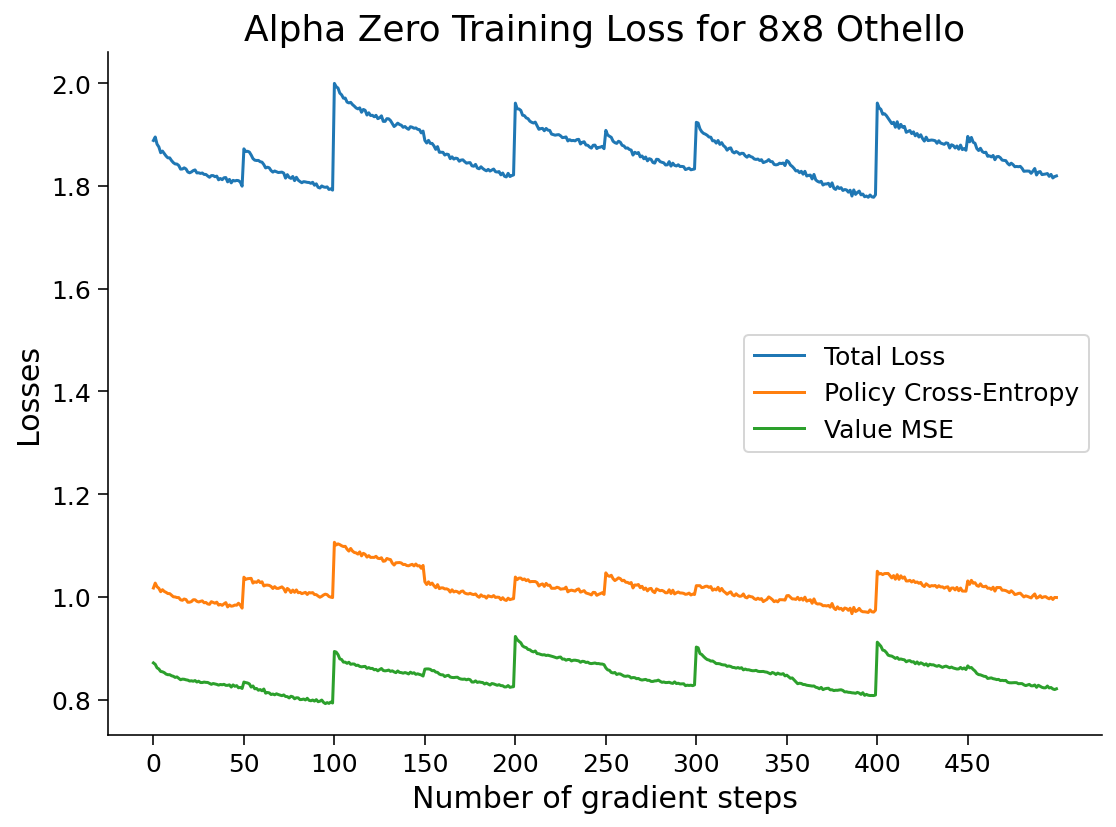

In [29]:
# @markdown Plot training loss
plt.plot(l)
plt.plot(p_l)
plt.plot(v_l)
plt.legend(["Total Loss", "Policy Cross-Entropy", "Value MSE"])
plt.xlabel('Number of gradient steps')
plt.xticks(np.arange(0,len(l),len(l)//10))
plt.ylabel('Losses')
plt.title(f'Alpha Zero Training Loss for {n}x{n} Othello')
plt.show()




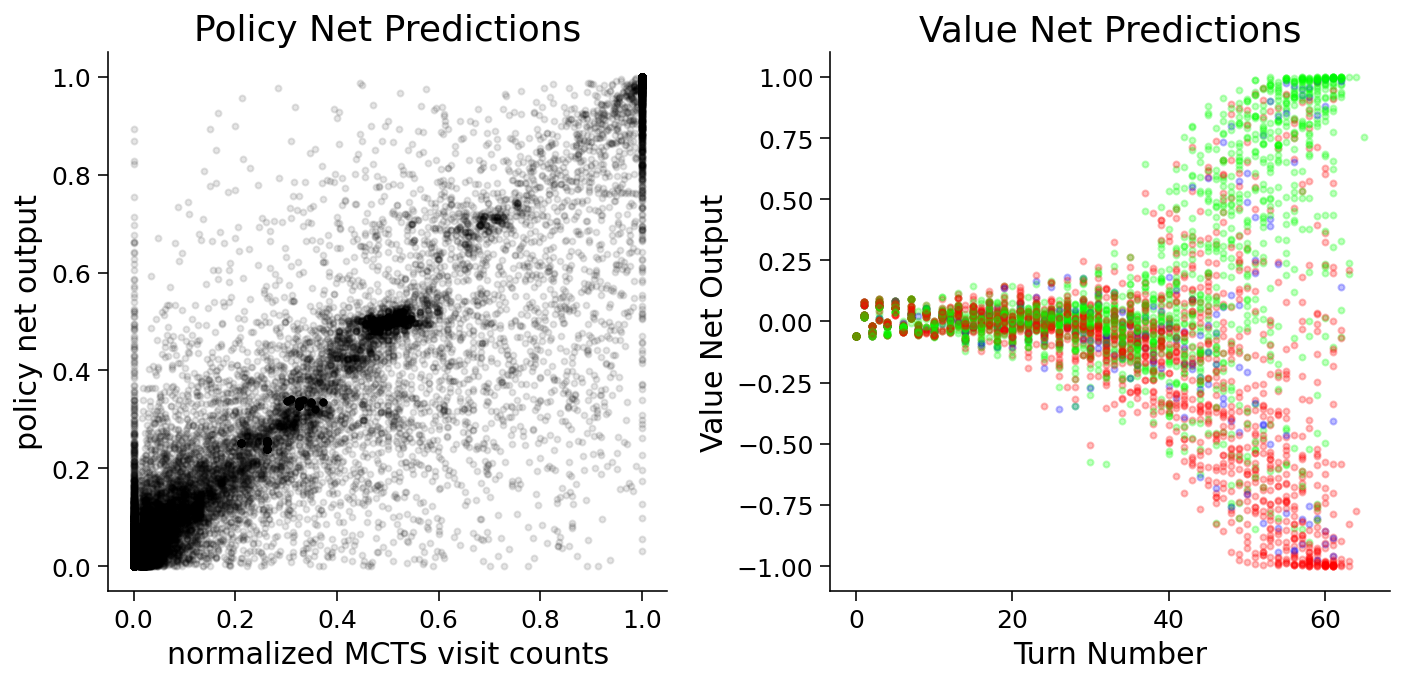

In [30]:
# @markdown Visualize outcome

def outcome2color(outcome, alpha=1):
    """Return RGB color for given outcome (-1, 0, +1)
    """
    if outcome == +1:
        return (0, 1, 0, alpha) # Win as green
    elif outcome == -1:
        return (1, 0, 0, alpha) # Loss as red
    else:
        return (0, 0, 1, alpha) # Draw as blue

pol_val_net.eval()
alpha_zero_agent = MCTSagent_from_net(pol_val_net, n, 100, 20)
alpha_zero_agent.temperature = 0.1
outcomes, raw_states, raw_mcts_counts = ai_vs_ai(alpha_zero_agent, n_games=100,
                                                 n=n, callback=mcts_visits_callback)
plt.figure(figsize=(10,5))
ax1, ax2 = plt.subplot(1,2,1), plt.subplot(1,2,2)
for t in range(len(raw_states)):
    sgn = +1 if t % 2 == 0 else -1
    player = 1 if t % 2 == 0 else 2
    pol_pred, val_pred = pol_val_net(sgn*boards2nn(raw_states[t]))
    counts_t = raw_mcts_counts[t].view(-1, n*n)
    targets_t = counts_t / counts_t.sum(dim=1, keepdim=True)
    valid = ~torch.any(torch.isnan(raw_states[t][:,0,0]))
    ax1.scatter(targets_t[valid,...].cpu().T, 
                pol_pred[valid,...].detach().exp().view(-1, n*n).cpu().T, 
                marker='.', c = 'k', alpha=.1)
    for g in range(len(raw_states)):
        if not torch.isnan(raw_states[t][g,0,0]):
            ax2.plot(t, val_pred[g].item(), marker='.', 
                      color=outcome2color(outcomes[g,player-1], 0.25))
  
ax1.set_xlabel('normalized MCTS visit counts')
ax1.set_ylabel('policy net output')
ax1.set_title('Policy Net Predictions')
ax2.set_xlabel('Turn Number')
ax2.set_ylabel('Value Net Output')
ax2.set_title('Value Net Predictions')
plt.show()

## Play a game against your trained agent

Let's wrap up by playing a game against your own agent. Have fun!

Begin Player 1's turn
Input move by clicking the board


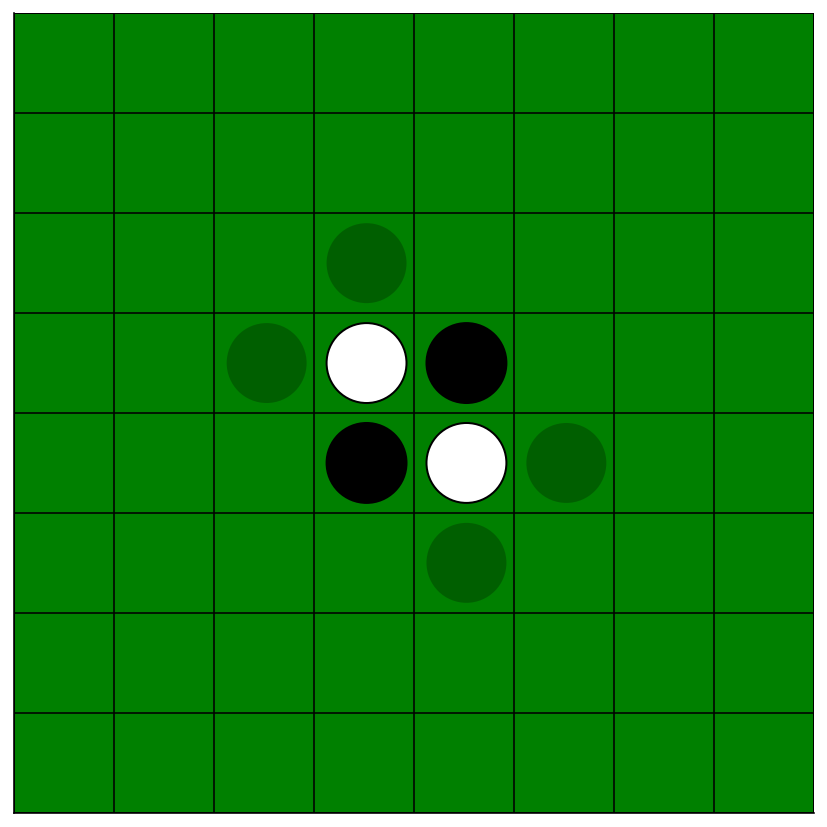

<IPython.core.display.Javascript object>

In [31]:
alpha_zero_agent = MCTSagent_from_net(pol_val_net, n=8, games_per_iter=1,
                                      num_mcts_search=50)
alpha_zero_agent.temperature = 0.1
interface = InteractiveOthelloGame(player1='human',
                                   player2=alpha_zero_agent, n=n)
interface.next_turn()

---
# Wrap up

In [32]:
import time
import numpy as np
import urllib.parse
from IPython.display import IFrame

#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**


def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()


#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: dagger_relabel;
except NameError: dagger_relabel = ""
try: reward_function;
except NameError: reward_function = ""
try: value_estimate;
except NameError: value_estimate = ""
try: c_puct;
except NameError: c_puct = ""
try: policy_iteration;
except NameError: policy_iteration = ""
try: on_off_policy;
except NameError: on_off_policy = ""
try: model;
except NameError: model = ""
try: remaining_questions;
except NameError: remaining_questions = ""

times = np.array([t1])-t0

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "dagger_relabel": dagger_relabel,
          "reward_function": reward_function,
          "value_estimate": value_estimate,
          "c_puct": c_puct,
          "policy_iteration": policy_iteration,
          "on_off_policy": on_off_policy,
          "model": model,
          "remaining_questions": remaining_questions,
          "cumulative_times": times}

src = "https://airtable.com/embed/shr0mEmUMsPA1dEzV?"


# now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400));

## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shrNSJ5ECXhNhsYss">https://airtable.com/shrNSJ5ECXhNhsYss</a>

In [ ]:
display(IFrame(src="https://airtable.com/embed/shrNSJ5ECXhNhsYss?backgroundColor=red", width = 800, height = 400))